In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Завантаження попередньо підготовлених датасетів**

In [3]:
path_users = './data/Normalized_dataset_users.csv'
path_features = './data/Normalized_dataset_features.csv'
path_user_profiles = './data/User_Profiles.csv'

In [4]:
df_users = pd.read_csv(path_users, on_bad_lines='skip')
df_users.shape

(9711301, 4)

In [5]:
df_features = pd.read_csv(path_features, on_bad_lines='skip')
df_features.shape

(50683, 18)

In [6]:
df_profiles = pd.read_csv(path_user_profiles, on_bad_lines='skip', index_col='Unnamed: 0')
df_profiles.shape

(1000, 12)

In [7]:
df_profiles.sample()

danceability    energy       key  \
42bb9fb711d598abe6a8a01ac0c6bc2f0d0e67e5      0.577762  0.574395  0.486042   

                                          loudness      mode  speechiness  \
42bb9fb711d598abe6a8a01ac0c6bc2f0d0e67e5  0.795338  0.665354     0.060418   

                                          acousticness  instrumentalness  \
42bb9fb711d598abe6a8a01ac0c6bc2f0d0e67e5      0.342025          0.205992   

                                          liveness   valence     tempo  \
42bb9fb711d598abe6a8a01ac0c6bc2f0d0e67e5  0.182811  0.462174  0.510834   

                                          time_signature  
42bb9fb711d598abe6a8a01ac0c6bc2f0d0e67e5        0.770079

## **Процес кластеризації**

імпортуємо dendrogram для побудови (візуалізації) ієрархічної кластеризацію у вигляді дендрограми

документація: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram

In [8]:
from scipy.cluster.hierarchy import dendrogram

імпортуємо AgglomerativeClustering для виконання об'єднувальної кластеризації ("знизу-вгору")

документація: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

In [9]:
from sklearn.cluster import AgglomerativeClustering

Імпортуємо PCA (Principal component analysis) для виділення основних компоненттів.

документація: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [30]:
from sklearn.decomposition import PCA

Імпортуємо normalize для порівняння кластеризації нормалізованих і ненормалізованих даних. Ця функція перетворює кожен рядок так, щоб довжина дорівнювала одиниці

документація: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

In [31]:
from sklearn.preprocessing import normalize

Імпортуємо Axes3D для подальших 3d візуалізацій

документація: https://matplotlib.org/3.5.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html

In [49]:
from mpl_toolkits.mplot3d import Axes3D

документація: https://docs.python.org/3/library/collections.html#collections.Counter

In [81]:
from collections import Counter

In [95]:
def plot_clusters(
    df_profiles:pd.DataFrame,
    normalize:bool=False,
    n_components:int=2,
    n_clusters:int=3,
    distance_metrics:list=['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    linkage_methods:list=['complete', 'average', 'single'],
    figsize:tuple=(18, 12)
):
    X = normalize(df_profiles) if normalize else df_profiles
    
    n_clusters = n_clusters
    
    X_reduced = PCA(n_components=n_components).fit_transform(X)
    
    fig, axs = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=figsize)
    
    for j, linkage_method in enumerate(linkage_methods):
        for i, metric in enumerate(distance_metrics):
            idx = j * len(distance_metrics) + i + 1
            if n_components == 2:
                ax = fig.add_subplot(len(linkage_methods), len(distance_metrics), idx)
                model = AgglomerativeClustering(
                    n_clusters=n_clusters,
                    metric=metric,
                    linkage=linkage_method
                )
                labels = model.fit_predict(X)

                cluster_counts = Counter(labels)
                cluster_text = "\n".join([f"Кластер {k}: {v}" for k, v in sorted(cluster_counts.items())])

                ax.text(
                    0.95, 0.05, cluster_text,
                    transform=ax.transAxes,
                    fontsize=7,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
                )
            
                ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='rainbow')
                ax.set_title(f'{metric} distance\n{linkage_method}')
            elif n_components == 3:
                ax = fig.add_subplot(len(linkage_methods), len(distance_metrics), idx, projection='3d')
        
                try:
                    model = AgglomerativeClustering(
                        n_clusters=n_clusters,
                        metric=metric,
                        linkage=linkage_method
                    )
                    labels = model.fit_predict(X)

                    cluster_counts = Counter(labels)
                    cluster_text = "\n".join([f"Кластер {k}: {v}" for k, v in sorted(cluster_counts.items())])
    
                    ax.text2D(
                        0.95, 0.05, cluster_text,
                        transform=ax.transAxes,
                        fontsize=7,
                        verticalalignment='bottom',
                        horizontalalignment='right',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
                    )
        
                    ax.scatter(
                        X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
                        c=labels, cmap='rainbow', s=15
                    )
                    ax.set_title(f'{metric}\n{linkage_method}', fontsize=8)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_zticks([])
                except Exception as e:
                    ax.text2D(0.1, 0.5, f'Error:\n{e}', transform=ax.transAxes)
                    ax.set_title(f'{metric}\n{linkage_method}', fontsize=8)
    
    plt.suptitle(f'Кластеризація ієрархічним методом', fontsize=16)
    plt.tight_layout()
    plt.show()

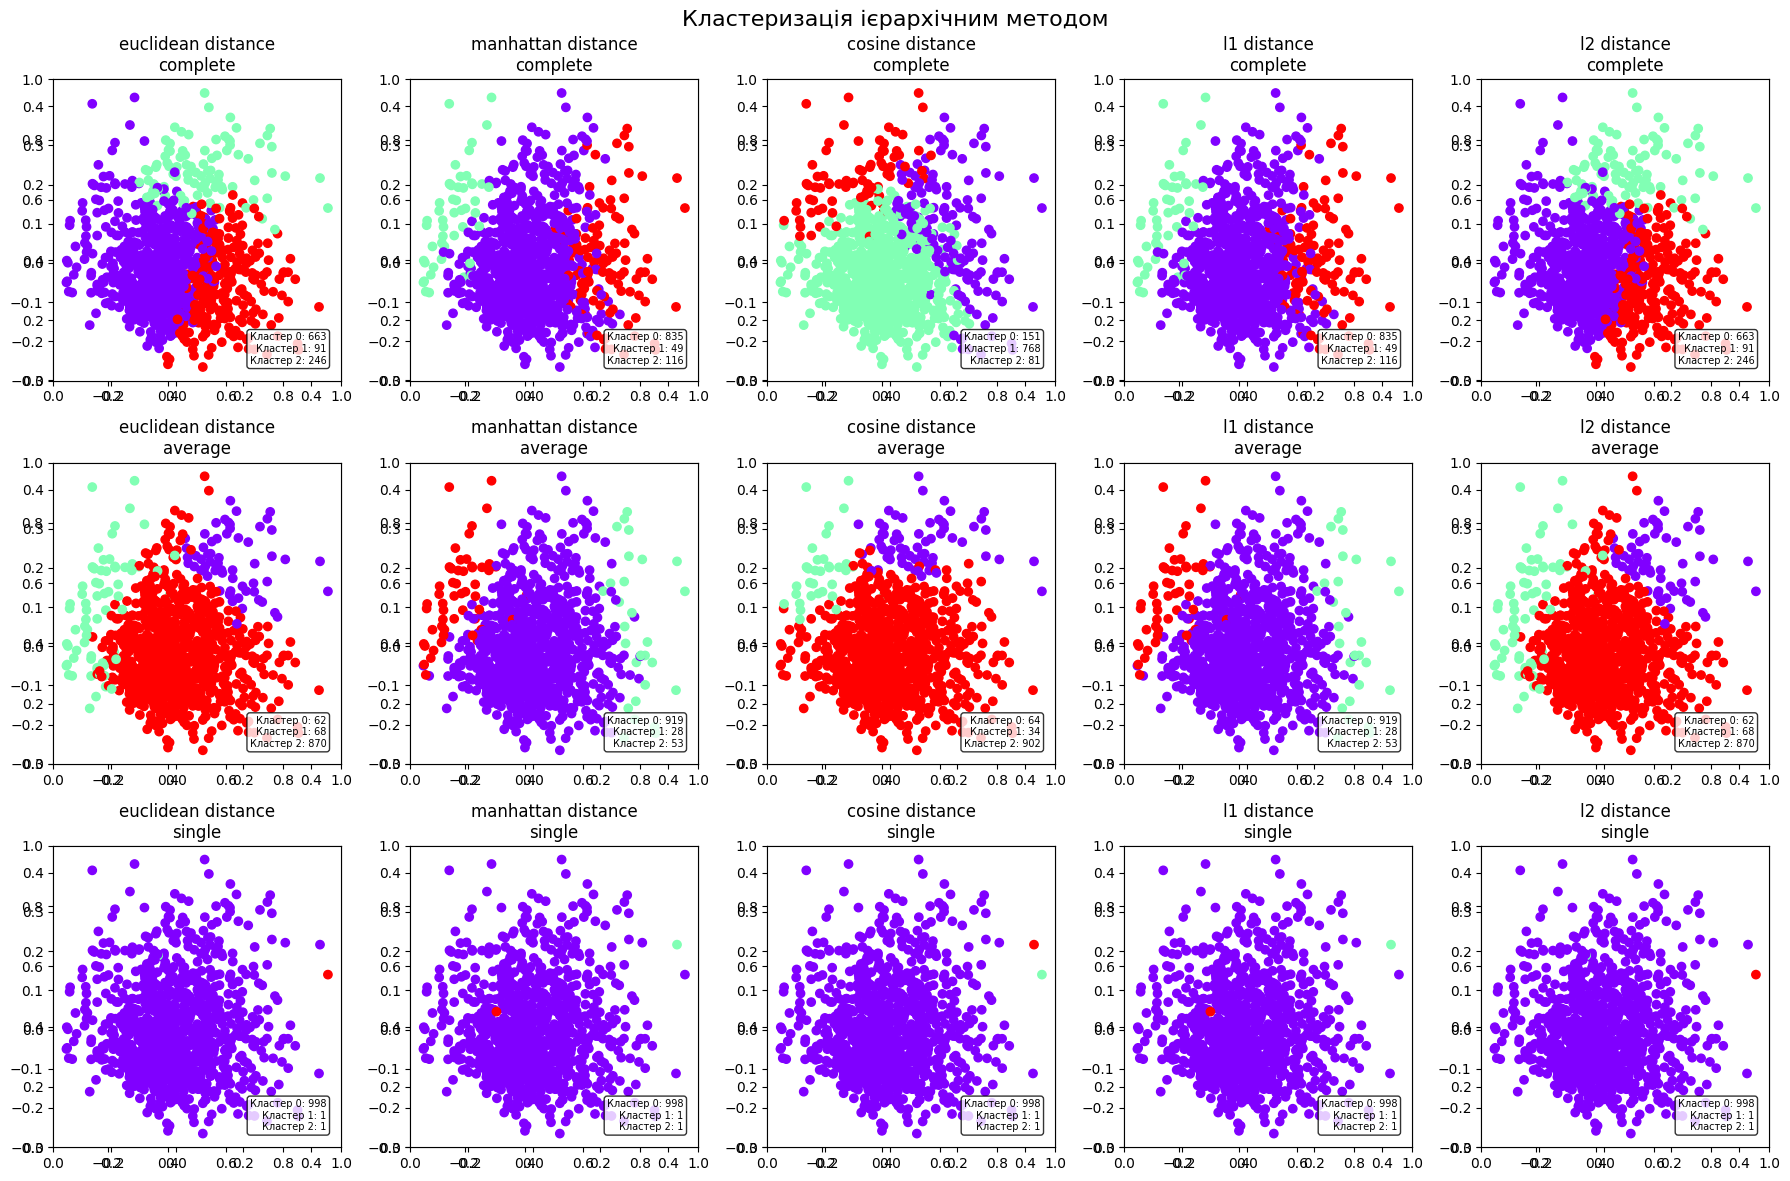

In [96]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=2, n_clusters=3)

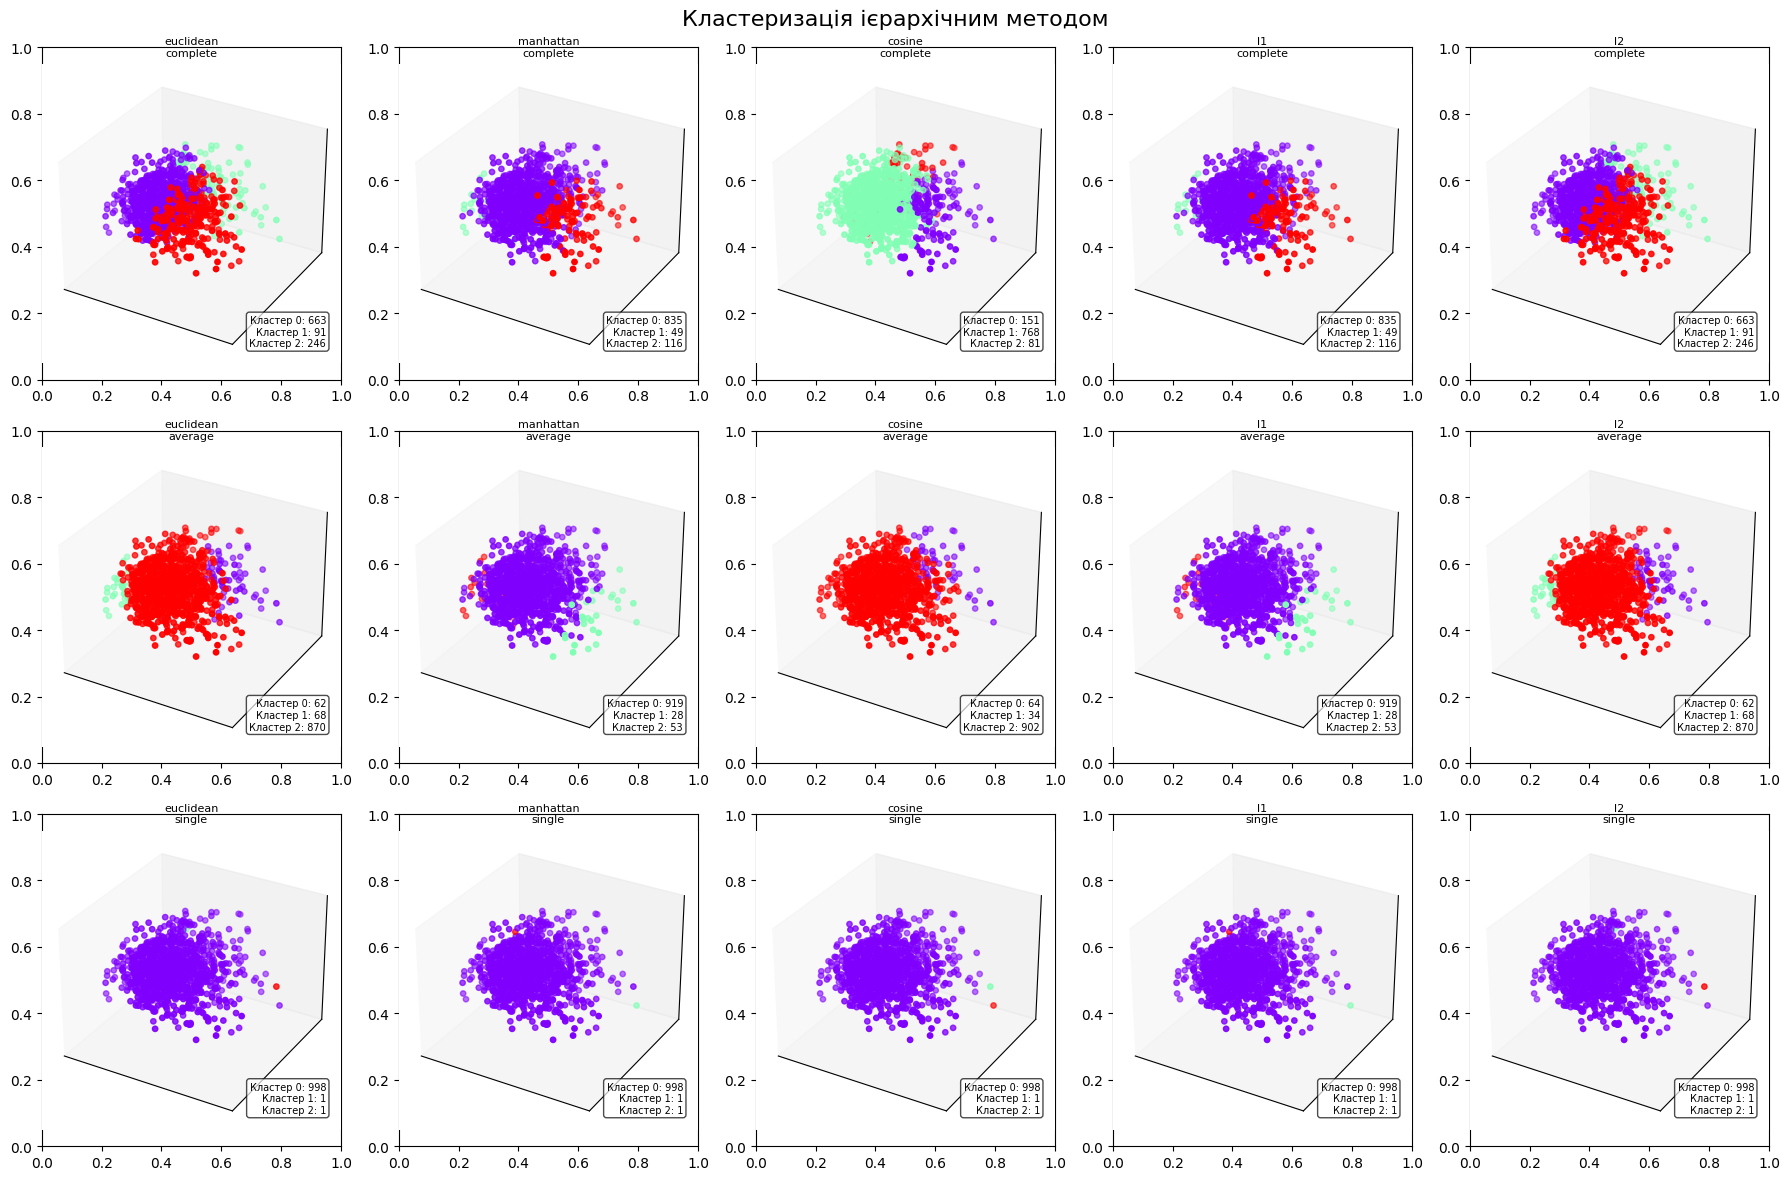

In [97]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=3, n_clusters=3)

З візуалізації помітно, що l1 дистанція - це те саме, що й Мангеттенська дистанція, а l2 - косинусна.

Також помітно, що значення критерію зв'язку (linkage criterion) 'single' неефективне.

Кратерій зв'язку 'average' не такий поганий, як 'single', проте також розділяє дані на нерівномірні кластери.

Тому зупинимося на критерії зв'язку 'complete' і переглянемо зміни на кількості кластерів.

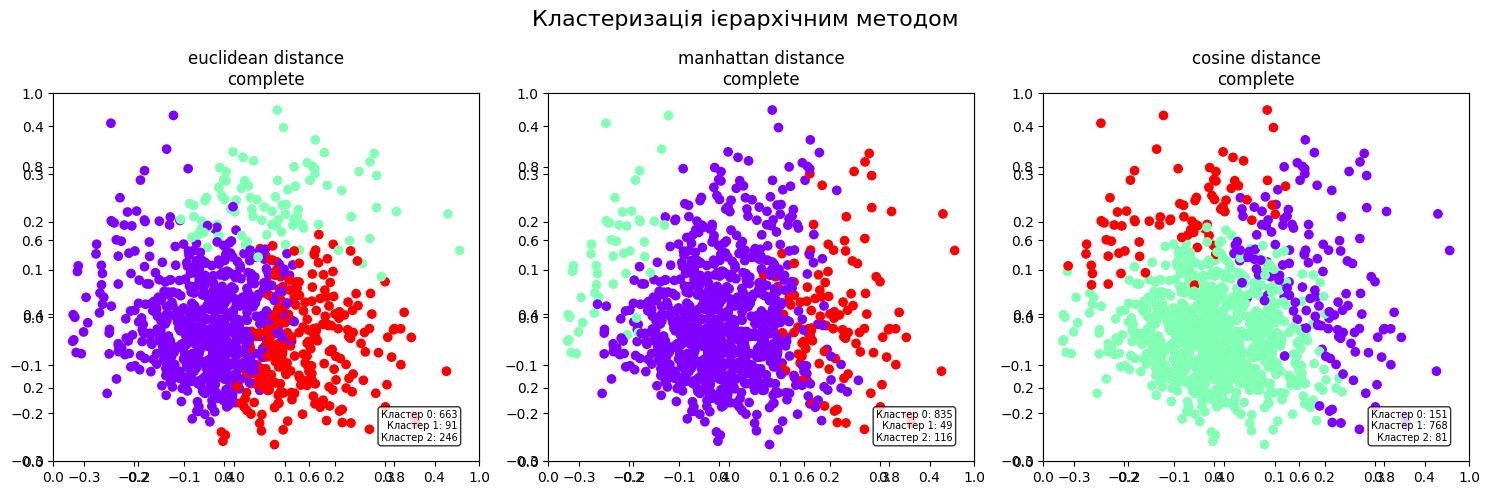

In [98]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=2, n_clusters=3, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

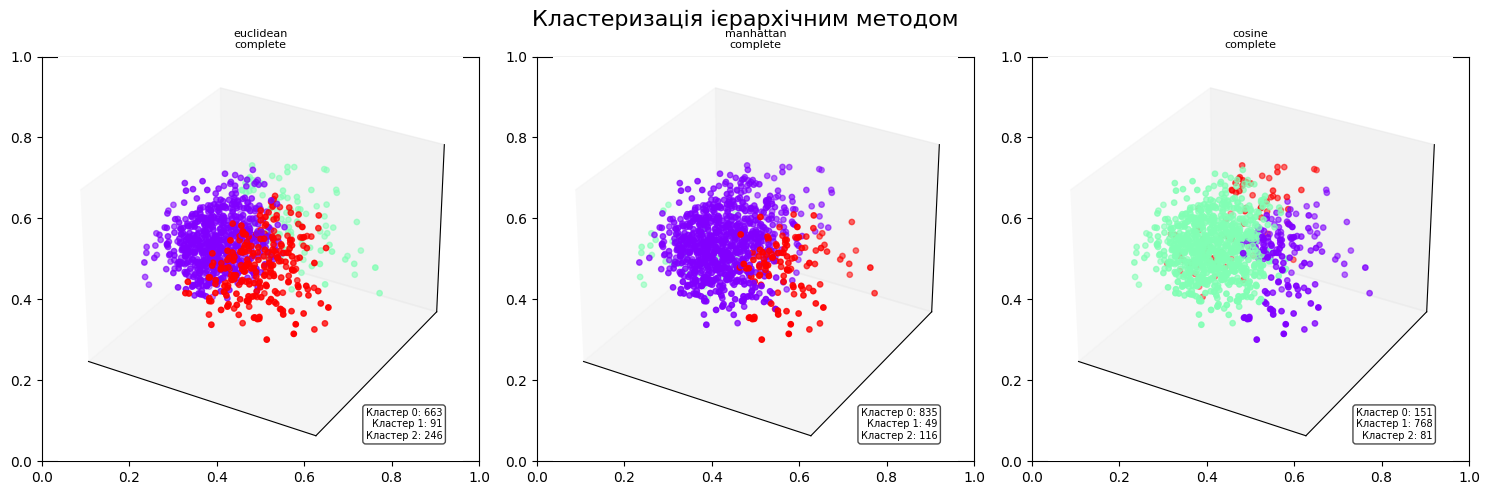

In [99]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=3, n_clusters=3, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

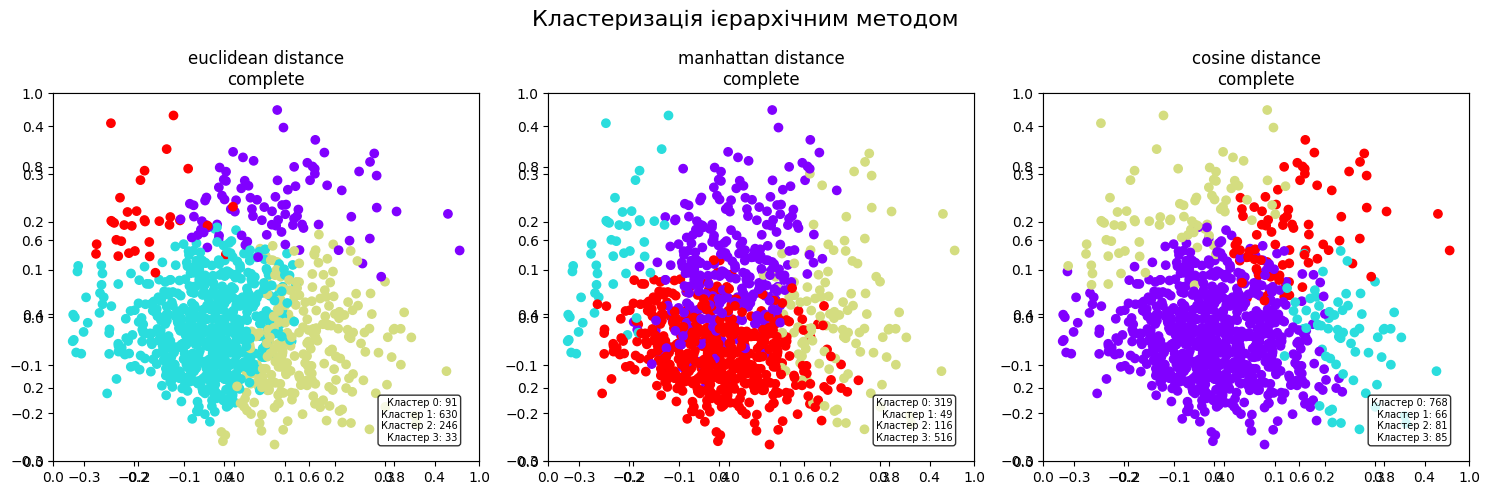

In [100]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=2, n_clusters=4, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

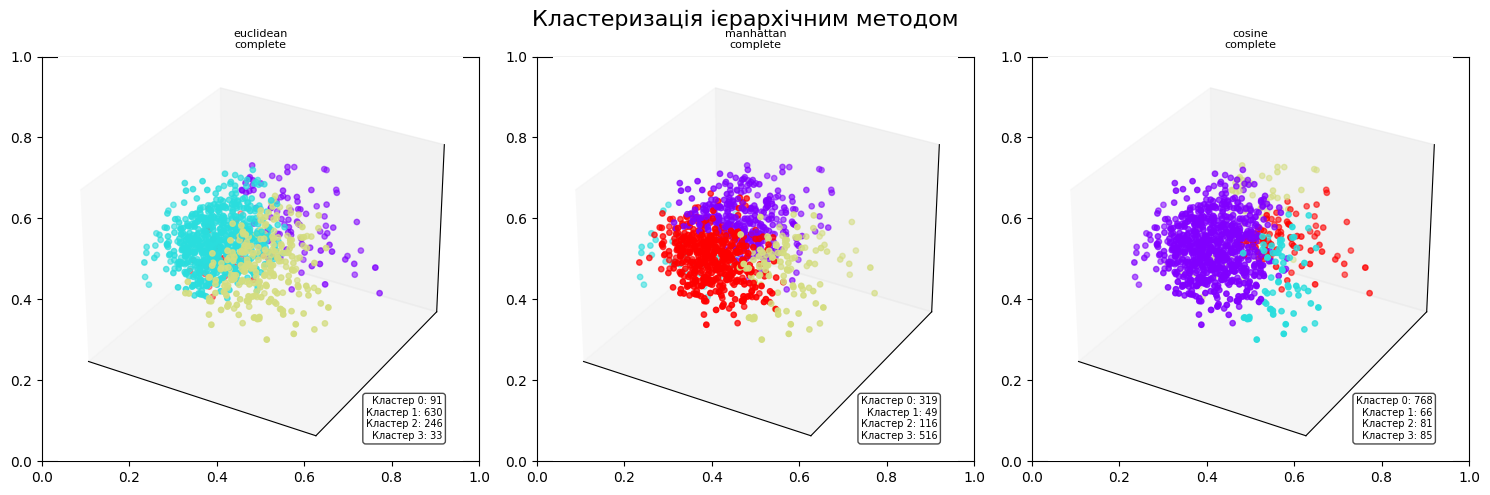

In [101]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=3, n_clusters=4, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

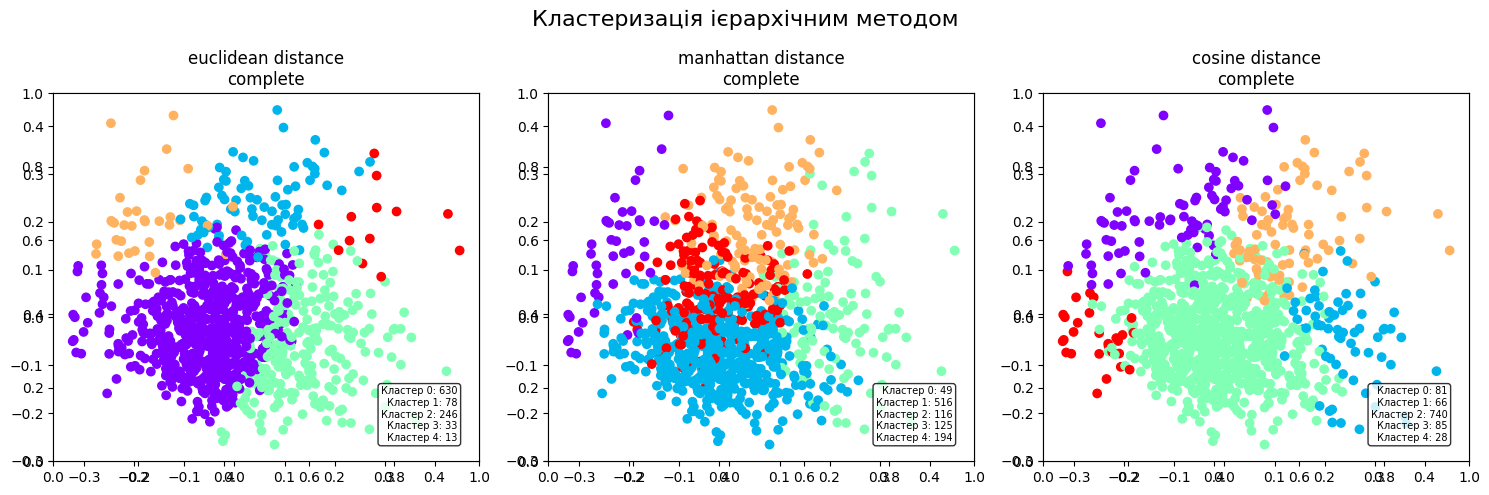

In [102]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=2, n_clusters=5, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

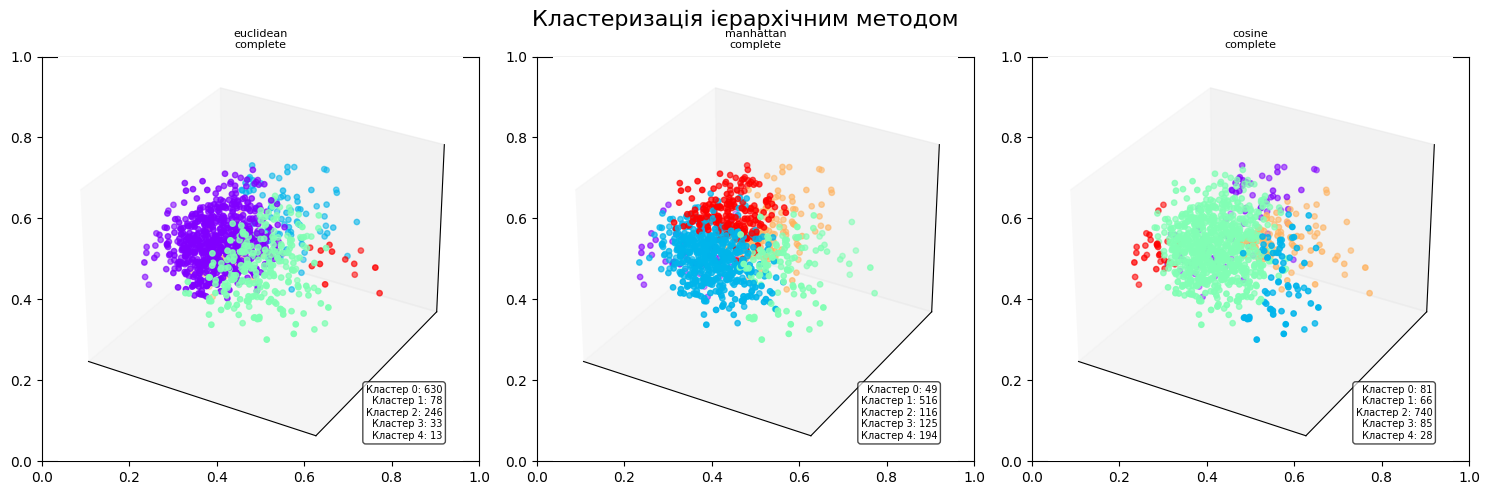

In [103]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=3, n_clusters=5, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

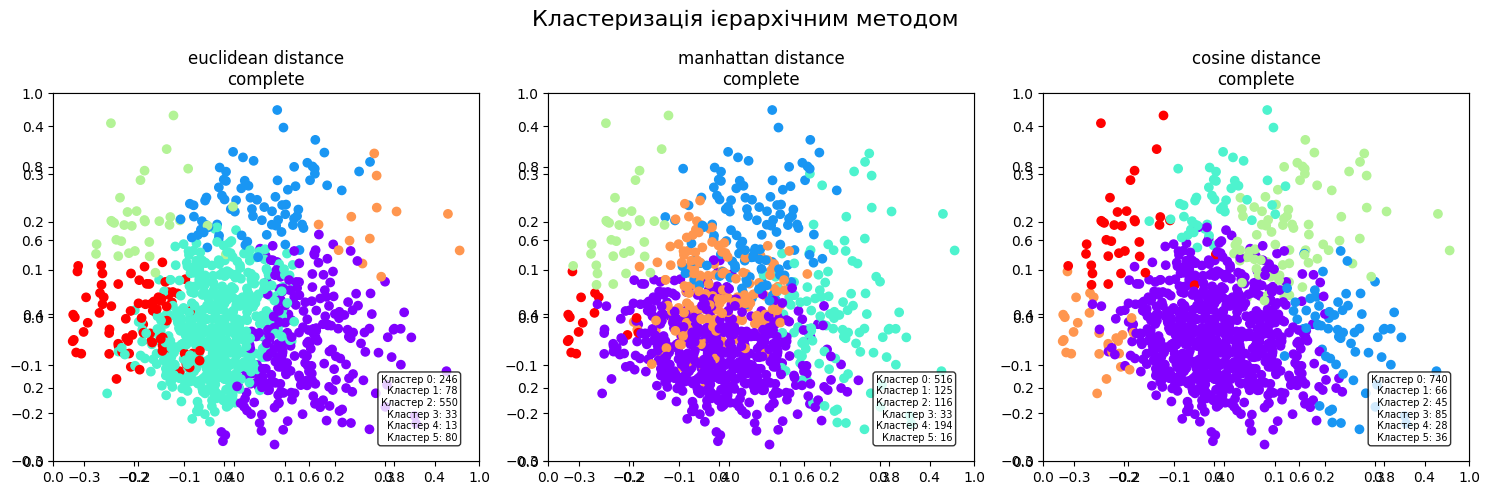

In [104]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=2, n_clusters=6, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

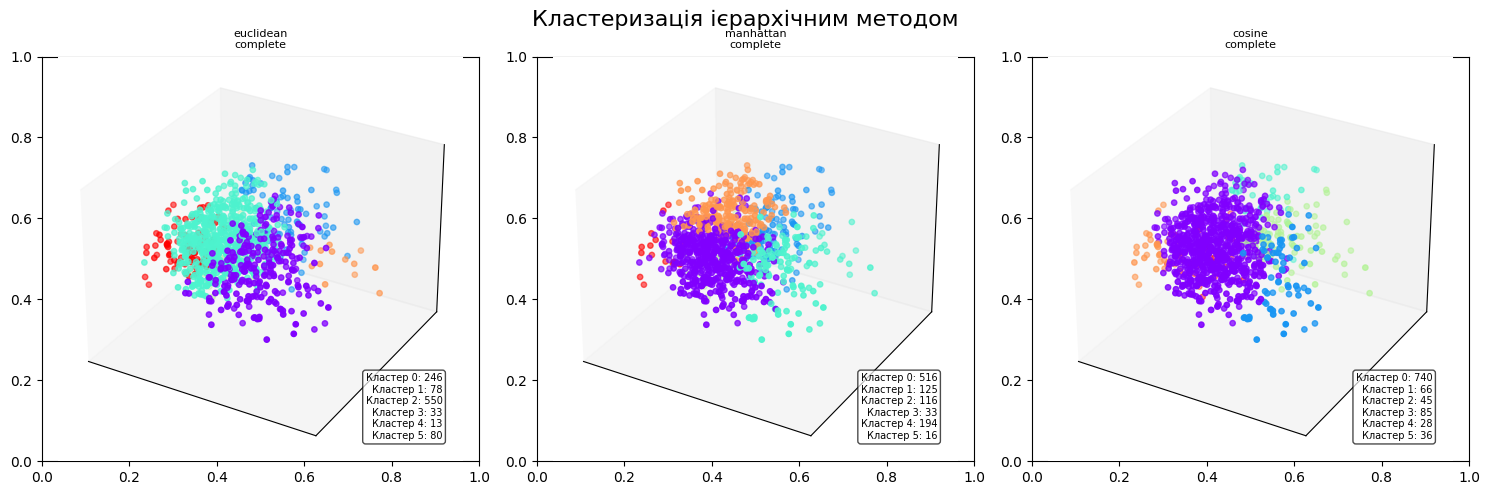

In [105]:
plot_clusters(df_profiles=df_profiles, normalize=False, n_components=3, n_clusters=6, 
              distance_metrics=['euclidean', 'manhattan', 'cosine'], 
              linkage_methods=['complete'], figsize=(15,5))

Імпортуємо метрику silhouette_score, яка показує, наскільки добре об'єкти відокремлені один від одного між кластерами, і наскільки схожі об'єкти в одному кластері.

документація: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [109]:
from sklearn.metrics import silhouette_score

In [146]:
def count_silhouette_scores(X, min:int=2, max:int=50):
    silhouette_scores = []
    for n in range(min, max):
        model = AgglomerativeClustering(n_clusters=n, linkage='complete')
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    return silhouette_scores

In [147]:
def plot_silhouette_scores(silhouette_scores):
    plt.figure(figsize=(20,5))
    plt.plot(range(2, 50), silhouette_scores, marker='o', color='maroon')
    plt.xticks(ticks=(range(2,50)))
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('silhouette_score')
    plt.grid()
    plt.show()

## **Не нормалізовані дані**

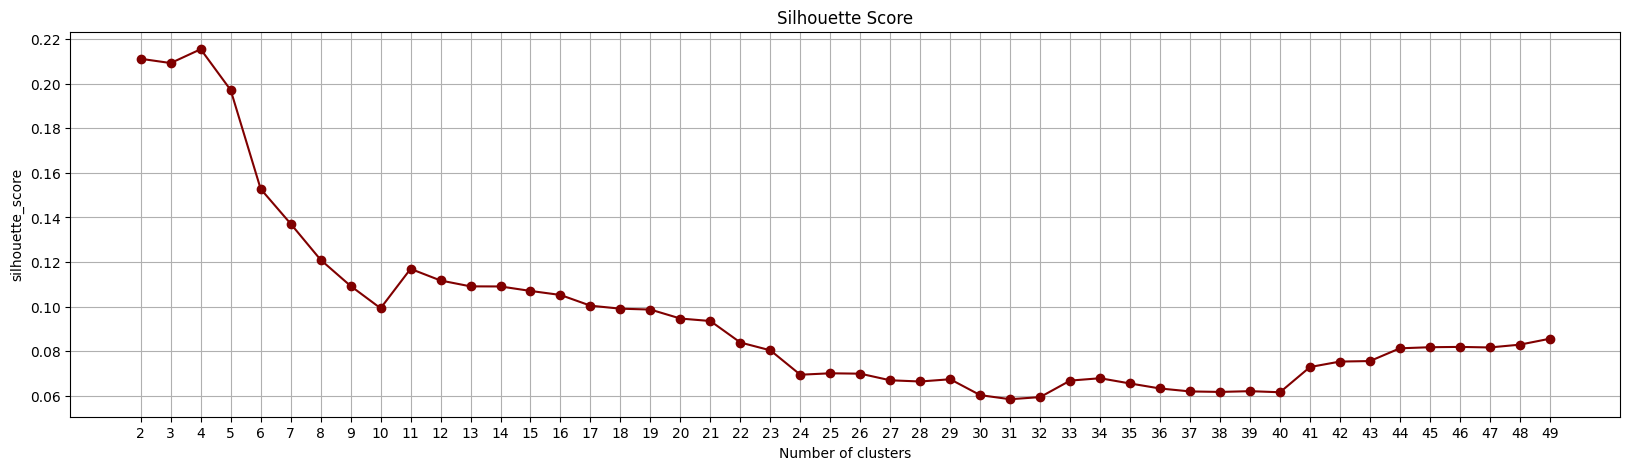

In [148]:
plot_silhouette_scores(silhouette_scores=count_silhouette_scores(X=df_profiles))

Візуалізуймо на сфері кластери для k={ 4 }

In [127]:
from prosphera.projector import Projector

In [128]:
visualizer = Projector(renderer='iframe')

In [129]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature']

In [160]:
X = df_profiles
X_reduced = PCA(n_components=3).fit_transform(X)
model = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels = model.fit_predict(X)

visualizer.project(
    data=X_reduced,
    labels=labels
)

## **Нормалізовані дані**

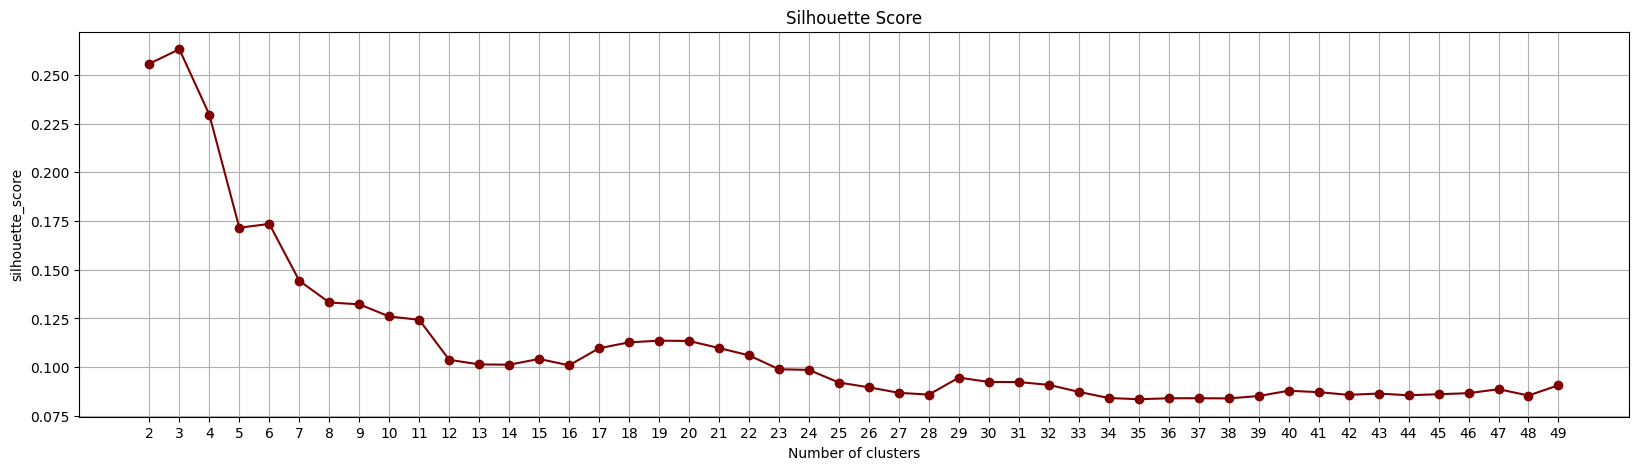

In [150]:
plot_silhouette_scores(silhouette_scores=count_silhouette_scores(X=normalize(df_profiles)))

Візуалізуймо на сфері кластери для k={ 3 }

In [152]:
X = normalize(df_profiles)
X_reduced = PCA(n_components=3).fit_transform(X)

In [156]:
model = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels = model.fit_predict(X)

visualizer.project(
    data=X_reduced,
    labels=labels
)

# **Припустимо, що оптимальна кількість кластерів = 4**

# **Перевіримо розподіл даних на обраних кластеризаціях**

In [161]:
X = df_profiles
X_reduced = PCA(n_components=3).fit_transform(X)
model = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels = model.fit_predict(X)

In [163]:
df_profiles['cluster'] = labels

In [164]:
df_profiles.sample()

danceability    energy      key  \
9560966fa5a7d4785a96b542a4b8a4ce1de4258e      0.510523  0.758485  0.43129   

                                          loudness      mode  speechiness  \
9560966fa5a7d4785a96b542a4b8a4ce1de4258e  0.839742  0.604651     0.064496   

                                          acousticness  instrumentalness  \
9560966fa5a7d4785a96b542a4b8a4ce1de4258e      0.112895          0.124661   

                                          liveness   valence     tempo  \
9560966fa5a7d4785a96b542a4b8a4ce1de4258e  0.190838  0.487254  0.517654   

                                          time_signature  cluster  
9560966fa5a7d4785a96b542a4b8a4ce1de4258e        0.791628        1

In [165]:
df_profiles['cluster'].value_counts(normalize=True)

cluster
1    0.630
2    0.246
0    0.091
3    0.033
Name: proportion, dtype: float64

In [193]:
X = normalize(df_profiles)
X_reduced = PCA(n_components=3).fit_transform(X)
model = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels = model.fit_predict(X)

In [194]:
df_profiles['cluster_norm'] = labels

In [195]:
df_profiles.sample()

danceability    energy       key  \
user_id                                                                      
1f3f9613c751129468b65e578c283bbfe0cda238      0.505111  0.677394  0.463762   

                                          loudness     mode  speechiness  \
user_id                                                                    
1f3f9613c751129468b65e578c283bbfe0cda238  0.831682  0.75576     0.057164   

                                          acousticness  instrumentalness  \
user_id                                                                    
1f3f9613c751129468b65e578c283bbfe0cda238      0.213614          0.107104   

                                          liveness   valence     tempo  \
user_id                                                                  
1f3f9613c751129468b65e578c283bbfe0cda238   0.20247  0.459212  0.539462   

                                          time_signature  cluster  \
user_id                                                             
1f3f9613c751129468b65e578c283bbfe0cda238        0.779724        1   

                                          cluster_norm  
user_id                                                 
1f3f9613c751129468b65e578c283bbfe0cda238             2

In [196]:
df_profiles['cluster_norm'].value_counts(normalize=True)

cluster_norm
2    0.630
1    0.279
0    0.091
Name: proportion, dtype: float64

### **функція візуалізації**

In [166]:
def plot_all_features(data: pd.DataFrame,
                      type_of_graph: str = 'hist',
                      ncols: int = 3,
                      figsize: tuple = (20, 15),
                      features=features):

  n_features = len(features)
  nrows = (n_features + ncols - 1) // ncols

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  axes = axes.flatten()

  for i, feature in enumerate(features):
      ax = axes[i]
      col_data = data[feature]

      if type_of_graph == 'bar':
          col_data.value_counts().plot.bar(ax=ax, edgecolor='black', linewidth=1.2, color='maroon')
      else:
          col_data.hist(ax=ax, edgecolor='black', linewidth=1.2, color='maroon')

      ax.set_xlabel(feature)
      ax.set_ylabel('Кількість значень')
      ax.set_title(f'{feature}', fontdict={'weight': 'bold'})

      for patch in ax.patches:
          height = patch.get_height()
          label = f'{height}\n( {height / col_data.shape[0] * 100:.2f}% )'
          x = patch.get_x() + patch.get_width() / 2
          ax.text(x, height + 0.5, label, ha='center', va='bottom', fontsize=8)

  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [172]:
def plot_features_comparisson(data: pd.DataFrame,
                               cluster_column_name: str = 'cluster',
                               type_of_graph: str = 'hist',
                               figsize: tuple = (20, 45),
                               features=None):
    if features is None:
        features = data.select_dtypes(include='number').columns.tolist()

    n_clusters = data[cluster_column_name].nunique()
    n_features = len(features)
    total_plots = n_features * n_clusters

    ncols = n_clusters
    nrows = (total_plots + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        for j in range(n_clusters):
            plot_index = i * n_clusters + j
            ax = axes[plot_index]

            cluster_data = data[data[cluster_column_name] == j][feature]

            if type_of_graph == 'bar':
                cluster_data.value_counts().plot.bar(ax=ax, edgecolor='black', linewidth=1.2, color='maroon')
            else:
                cluster_data.hist(ax=ax, edgecolor='black', linewidth=1.2, color='maroon', bins=20)

            ax.set_xlabel(feature)
            ax.set_ylabel('Кількість значень')
            ax.set_title(f'{feature} — Кластер {j}', fontdict={'weight': 'bold'}, fontsize=10)

            if type_of_graph == 'bar':
                for patch in ax.patches:
                    height = patch.get_height()
                    if height > 0:
                        label = f'{height}\n({height / cluster_data.shape[0] * 100:.2f}%)'
                        x = patch.get_x() + patch.get_width() / 2
                        ax.text(x, height + 0.5, label, ha='center', va='bottom', fontsize=7)

    for k in range(total_plots, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()

In [171]:
def plot_features_comparisson_overlaping(data: pd.DataFrame,
                                         type_of_graph: str = 'hist',
                                         ncols: int = 3,
                                         cluster_column_name: str = 'cluster',
                                         figsize: tuple = (20, 15),
                                         features=features):

  if features is None:
      features = data.select_dtypes(include='number').columns.tolist()

  n_clusters = data[cluster_column_name].nunique()
  n_features = len(features)

  nrows = (n_features + ncols - 1) // ncols

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  axes = axes.flatten()

  for i, feature in enumerate(features):
      ax = axes[i]
      col_data_one = data[data[cluster_column_name] == 0][feature]
      col_data_two = data[data[cluster_column_name] == 1][feature]
      col_data_three = data[data[cluster_column_name] == 2][feature]
      col_data_four = data[data[cluster_column_name] == 3][feature]
      col_data_five = data[data[cluster_column_name] == 4][feature]

      colors = ['maroon', 'yellow', 'deepskyblue', 'forestgreen', 'purple']
      if type_of_graph == 'bar':
          col_data_one.value_counts().plot.bar(ax=ax, edgecolor='black', linewidth=1.2, color='maroon')
      else:
          col_data_one.hist(ax=ax, edgecolor='black', linewidth=1.2, color=colors[0], bins=20, alpha=0.2)
          col_data_two.hist(ax=ax, edgecolor='black', linewidth=1.2, color=colors[1], bins=20, alpha=0.2)
          col_data_three.hist(ax=ax, edgecolor='black', linewidth=1.2, color=colors[2], bins=20, alpha=0.2)
          col_data_four.hist(ax=ax, edgecolor='black', linewidth=1.2, color=colors[3], bins=20, alpha=0.2)
          col_data_five.hist(ax=ax, edgecolor='black', linewidth=1.2, color=colors[4], bins=20, alpha=0.2)

      ax.set_xlabel(feature)
      ax.set_ylabel('Кількість значень')
      ax.set_title(f'{feature}', fontdict={'weight': 'bold'})

  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [170]:
def plot_clusters_overlaping(data: pd.DataFrame,
                            cluster_column_name: str = 'cluster',
                            figsize: tuple = (20, 15),
                            features=features):

  n_clusters = data[cluster_column_name].nunique()
  clusters = data[cluster_column_name].unique()
  ncols = n_clusters

  n_features = len(features)
  nrows = (n_features + ncols - 1) // ncols

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  axes = axes.flatten()

  for i, cluster in enumerate(clusters):
      ax = axes[i]

      for feature in features:
        col_data = data[data[cluster_column_name] == cluster][feature]
        col_data.hist(ax=ax, edgecolor='black', linewidth=1.2, color='maroon', bins=20, alpha=0.2)

      ax.set_xlabel(cluster)
      ax.set_ylabel('Кількість значень')
      ax.set_title(f'{cluster}', fontdict={'weight': 'bold'})

  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

## **Переглянемо перший кластер**

In [174]:
expl_data = df_profiles[df_profiles['cluster'] == 0]

In [175]:
expl_data.sample(4)

danceability    energy       key  \
e91491291e776b92c4aec5327f6e8b7e15f04e38      0.632537  0.718929  0.539347   
a4a068221b97aad518af038628daf1180e30113a      0.643726  0.740130  0.556593   
b8e0d4695d705ac10a33bccaa2220409b0df1a79      0.472105  0.600952  0.409623   
c156a9ace5b79955fdaaafaeeb731cedef050c21      0.477890  0.691168  0.495650   

                                          loudness      mode  speechiness  \
e91491291e776b92c4aec5327f6e8b7e15f04e38  0.817983  0.619962     0.114925   
a4a068221b97aad518af038628daf1180e30113a  0.822800  0.533333     0.102362   
b8e0d4695d705ac10a33bccaa2220409b0df1a79  0.771122  0.545667     0.096927   
c156a9ace5b79955fdaaafaeeb731cedef050c21  0.803200  0.448845     0.062746   

                                          acousticness  instrumentalness  \
e91491291e776b92c4aec5327f6e8b7e15f04e38      0.136017          0.362932   
a4a068221b97aad518af038628daf1180e30113a      0.093774          0.407628   
b8e0d4695d705ac10a33bccaa2220409b0df1a79      0.374660          0.568741   
c156a9ace5b79955fdaaafaeeb731cedef050c21      0.148237          0.483302   

                                          liveness   valence     tempo  \
e91491291e776b92c4aec5327f6e8b7e15f04e38  0.230834  0.520039  0.509491   
a4a068221b97aad518af038628daf1180e30113a  0.212021  0.527100  0.539810   
b8e0d4695d705ac10a33bccaa2220409b0df1a79  0.220948  0.340661  0.484620   
c156a9ace5b79955fdaaafaeeb731cedef050c21  0.216480  0.361280  0.559070   

                                          time_signature  cluster  
e91491291e776b92c4aec5327f6e8b7e15f04e38        0.784261        0  
a4a068221b97aad518af038628daf1180e30113a        0.790270        0  
b8e0d4695d705ac10a33bccaa2220409b0df1a79        0.782201        0  
c156a9ace5b79955fdaaafaeeb731cedef050c21        0.751155        0

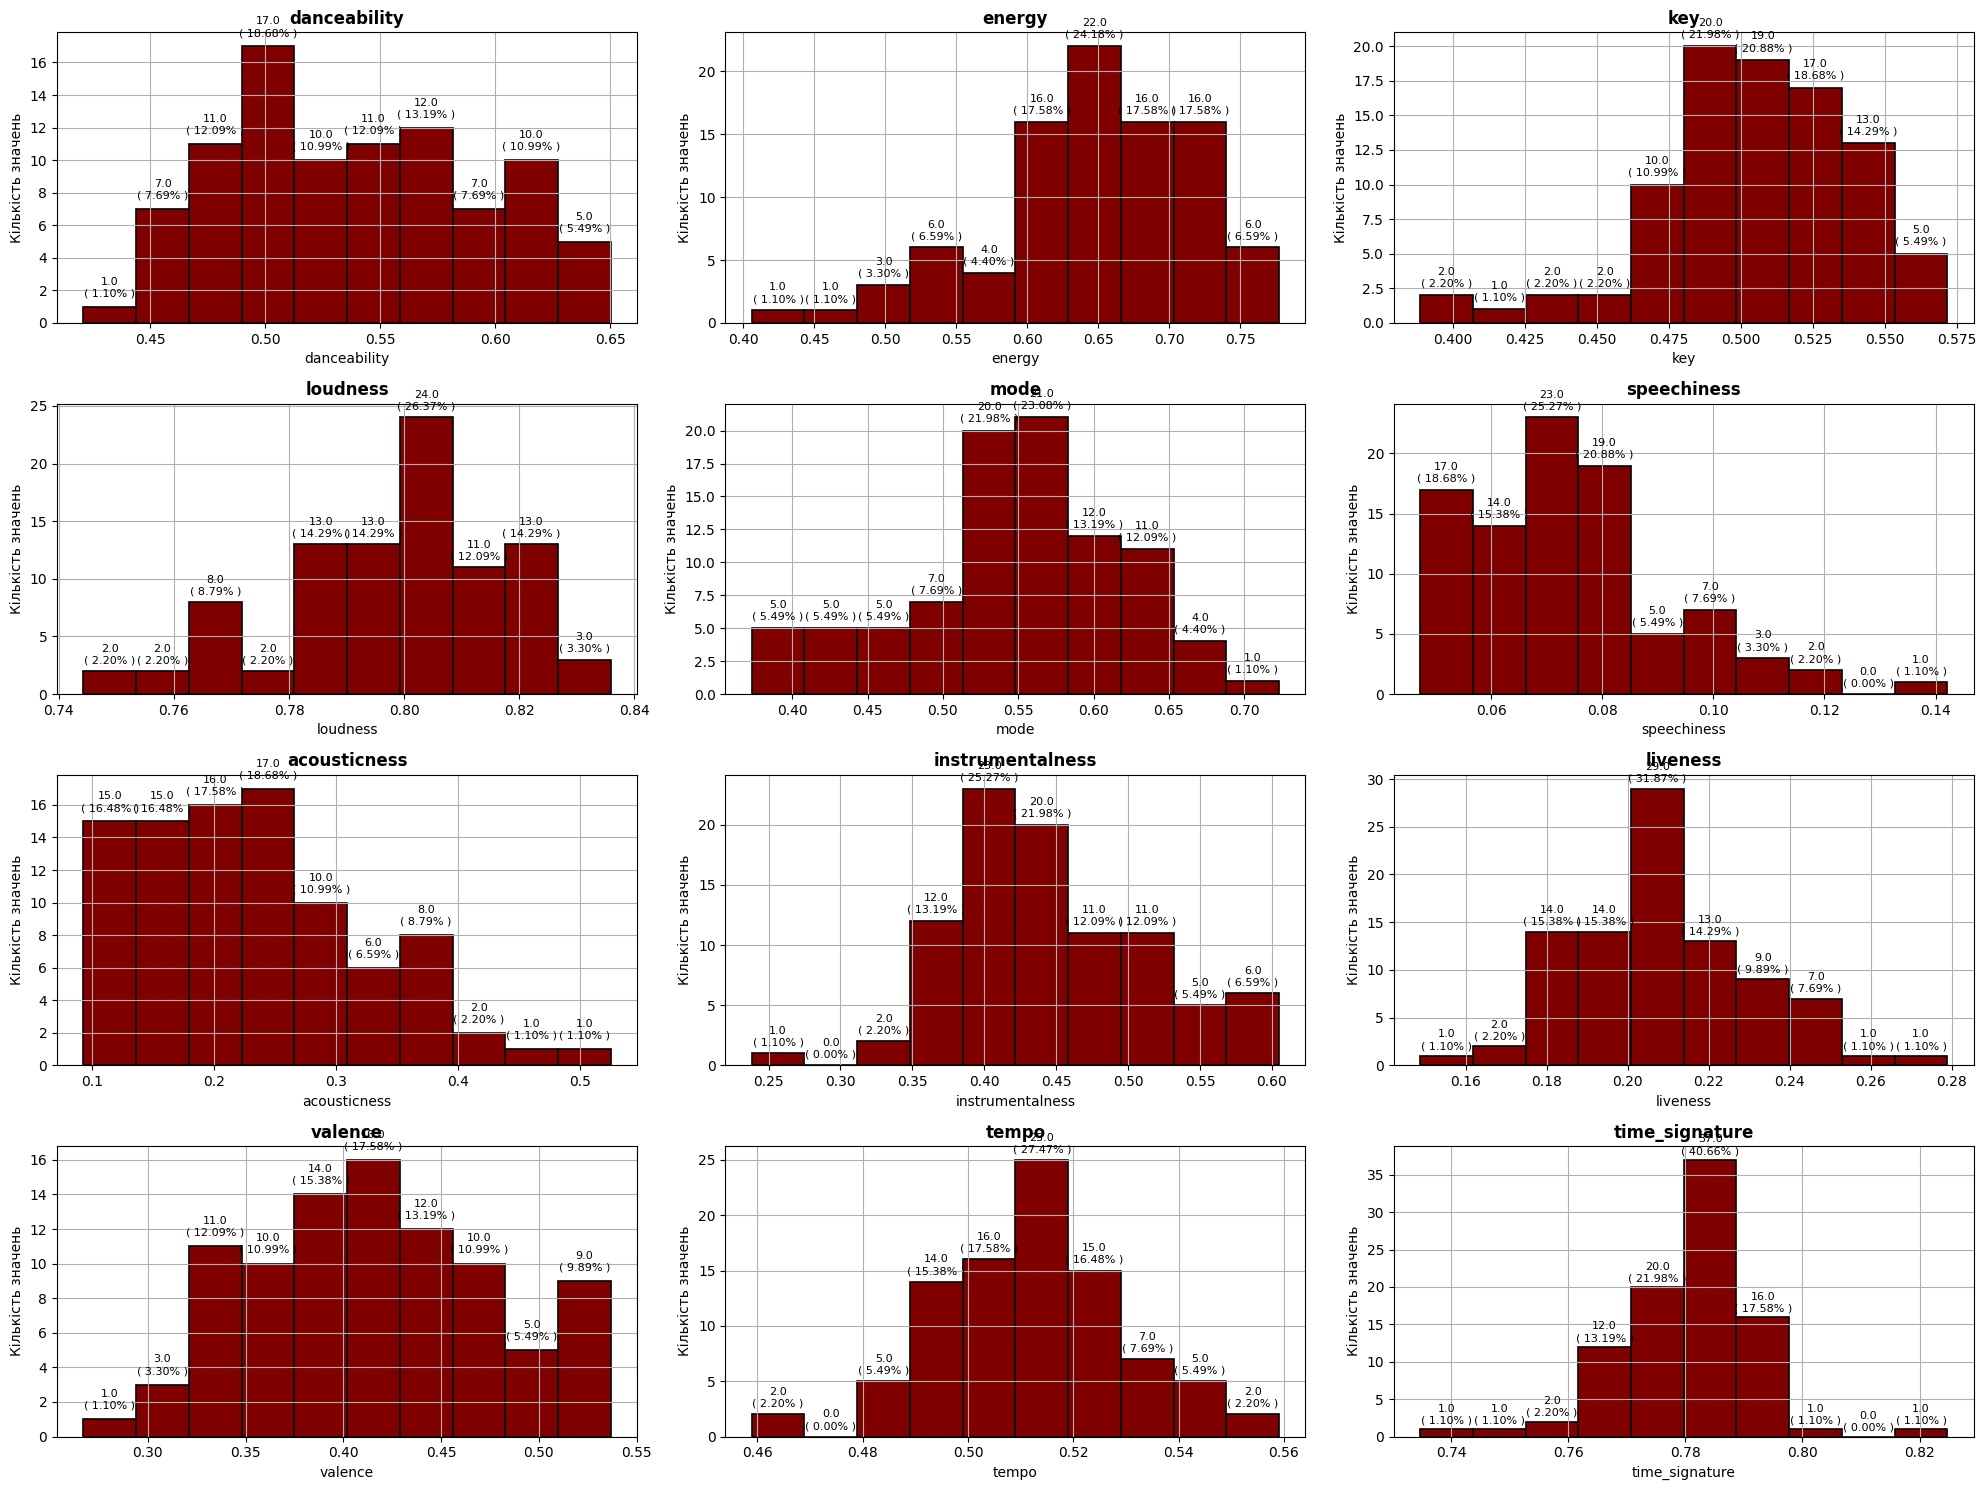

In [176]:
plot_all_features(data=expl_data)

## **Переглянемо другий кластер**

In [177]:
expl_data = df_profiles[df_profiles['cluster'] == 1]

In [178]:
expl_data.sample(4)

danceability    energy       key  \
d83d961366c8ca18d82f208946161d0969c27b5c      0.505979  0.606591  0.477620   
97f108efe890d76aa5fcc8b66e4d740a1944d5a7      0.478231  0.697631  0.503073   
13ce57b3a25ef63fa614335fd838e8024c42ec17      0.419575  0.775393  0.469875   
6ba7927851ffbec33619afea3893b8551ef36244      0.480879  0.741537  0.538434   

                                          loudness      mode  speechiness  \
d83d961366c8ca18d82f208946161d0969c27b5c  0.796891  0.642202     0.045950   
97f108efe890d76aa5fcc8b66e4d740a1944d5a7  0.814027  0.665480     0.083372   
13ce57b3a25ef63fa614335fd838e8024c42ec17  0.838405  0.602614     0.083683   
6ba7927851ffbec33619afea3893b8551ef36244  0.836266  0.732673     0.062590   

                                          acousticness  instrumentalness  \
d83d961366c8ca18d82f208946161d0969c27b5c      0.281433          0.131250   
97f108efe890d76aa5fcc8b66e4d740a1944d5a7      0.192313          0.271453   
13ce57b3a25ef63fa614335fd838e8024c42ec17      0.128272          0.149792   
6ba7927851ffbec33619afea3893b8551ef36244      0.125222          0.268867   

                                          liveness   valence     tempo  \
d83d961366c8ca18d82f208946161d0969c27b5c  0.194767  0.435231  0.518946   
97f108efe890d76aa5fcc8b66e4d740a1944d5a7  0.210035  0.412190  0.490453   
13ce57b3a25ef63fa614335fd838e8024c42ec17  0.246774  0.359284  0.530321   
6ba7927851ffbec33619afea3893b8551ef36244  0.197051  0.492337  0.516618   

                                          time_signature  cluster  
d83d961366c8ca18d82f208946161d0969c27b5c        0.761468        1  
97f108efe890d76aa5fcc8b66e4d740a1944d5a7        0.785053        1  
13ce57b3a25ef63fa614335fd838e8024c42ec17        0.746405        1  
6ba7927851ffbec33619afea3893b8551ef36244        0.784158        1

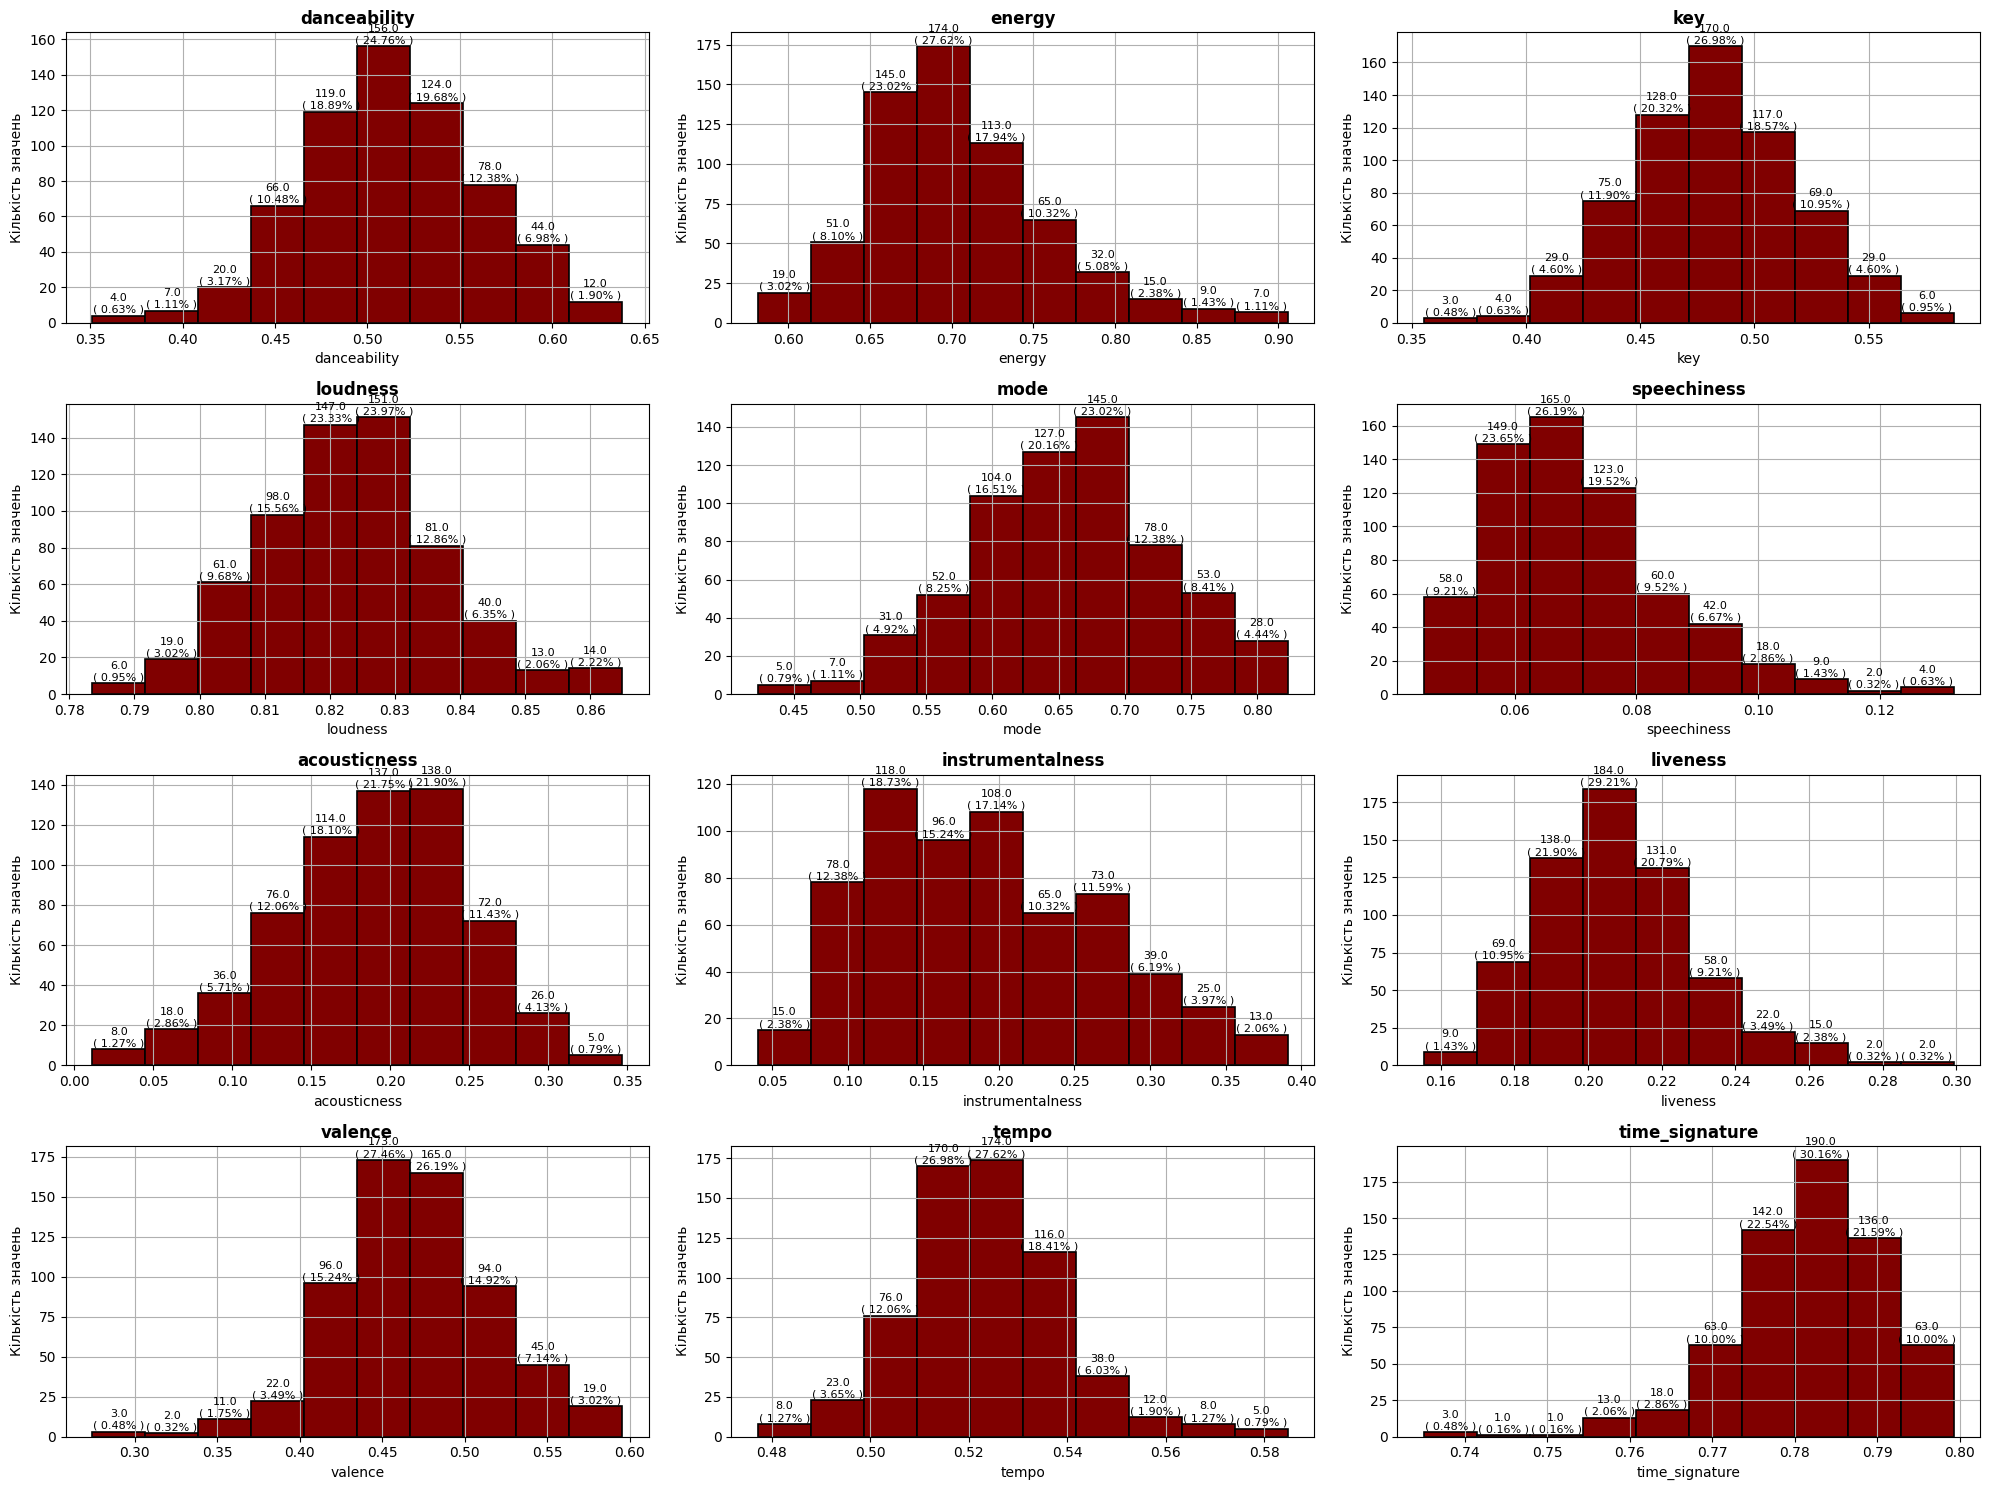

In [179]:
plot_all_features(data=expl_data)

## **Переглянемо третій кластер**

In [180]:
expl_data = df_profiles[df_profiles['cluster'] == 2]

In [181]:
expl_data.sample(4)

danceability    energy       key  \
3721337fa49341b562c7b85167b275104cb37430      0.536085  0.598843  0.443131   
bebeaccd02e67c4c5cb50442e0d8788b673a5a2c      0.540709  0.650078  0.538292   
0f3a76ae4c7df544feee40780eacc333ed83e1a5      0.551977  0.602631  0.472898   
c7439e024b3fc054c97153563222494f5d735226      0.508635  0.607529  0.410424   

                                          loudness      mode  speechiness  \
3721337fa49341b562c7b85167b275104cb37430  0.808570  0.775785     0.042296   
bebeaccd02e67c4c5cb50442e0d8788b673a5a2c  0.824147  0.609091     0.054785   
0f3a76ae4c7df544feee40780eacc333ed83e1a5  0.812105  0.699531     0.057762   
c7439e024b3fc054c97153563222494f5d735226  0.807521  0.808000     0.055887   

                                          acousticness  instrumentalness  \
3721337fa49341b562c7b85167b275104cb37430      0.331783          0.203937   
bebeaccd02e67c4c5cb50442e0d8788b673a5a2c      0.283268          0.161158   
0f3a76ae4c7df544feee40780eacc333ed83e1a5      0.331025          0.102752   
c7439e024b3fc054c97153563222494f5d735226      0.350313          0.115304   

                                          liveness   valence     tempo  \
3721337fa49341b562c7b85167b275104cb37430  0.164531  0.469089  0.497937   
bebeaccd02e67c4c5cb50442e0d8788b673a5a2c  0.190057  0.455436  0.522378   
0f3a76ae4c7df544feee40780eacc333ed83e1a5  0.168683  0.478772  0.509738   
c7439e024b3fc054c97153563222494f5d735226  0.182563  0.492089  0.517551   

                                          time_signature  cluster  
3721337fa49341b562c7b85167b275104cb37430        0.773094        2  
bebeaccd02e67c4c5cb50442e0d8788b673a5a2c        0.778182        2  
0f3a76ae4c7df544feee40780eacc333ed83e1a5        0.794366        2  
c7439e024b3fc054c97153563222494f5d735226        0.772267        2

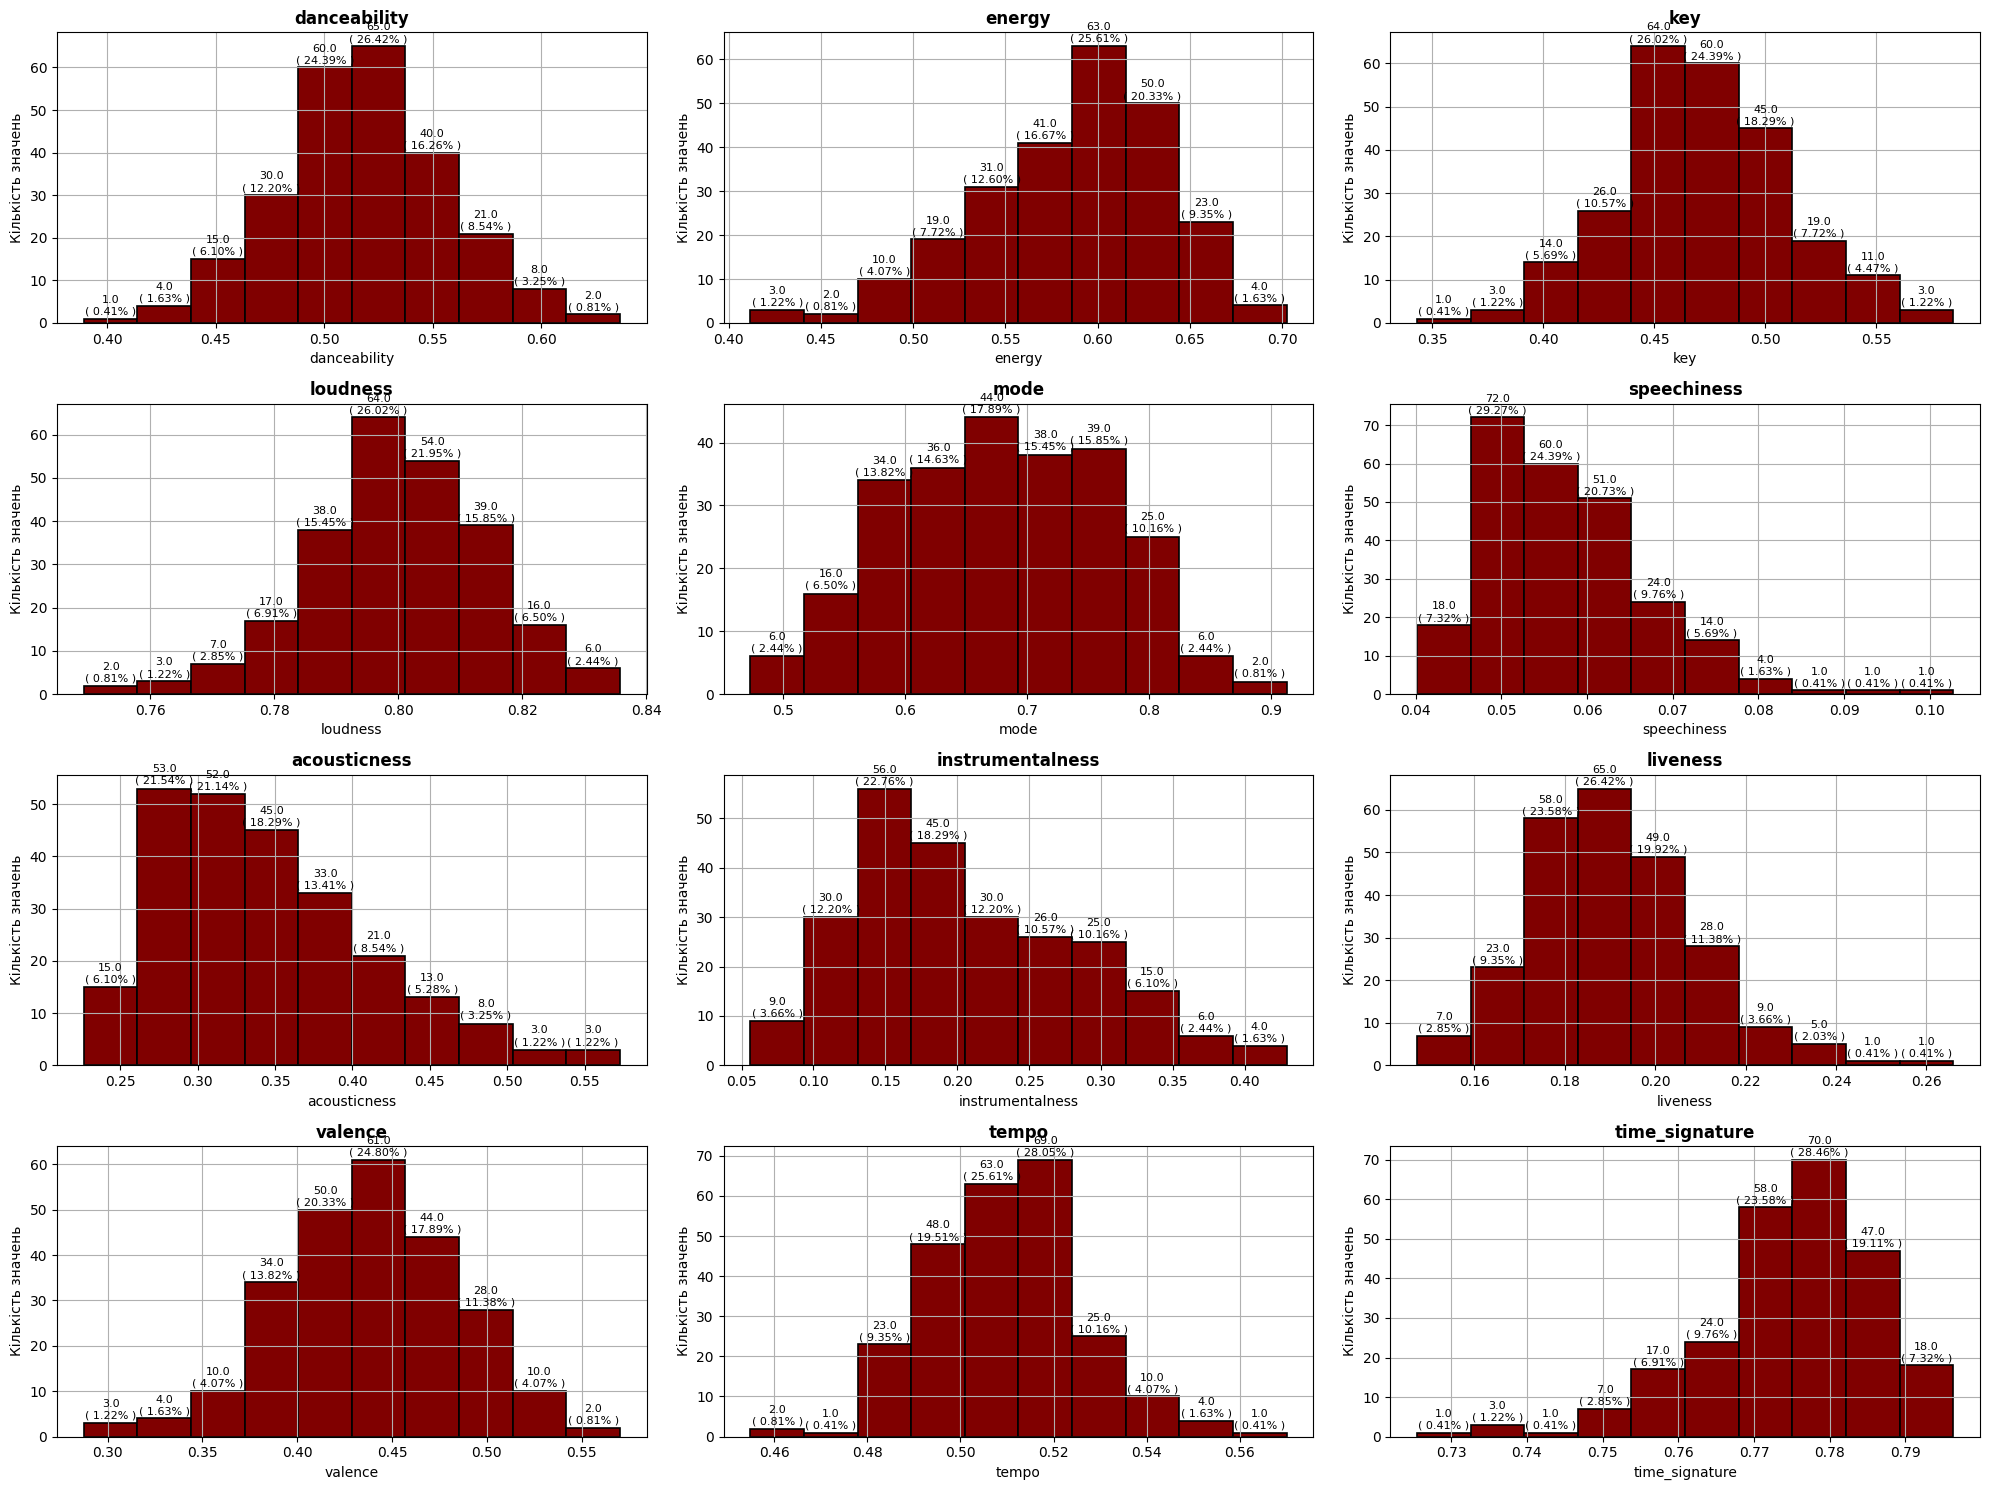

In [182]:
plot_all_features(data=expl_data)

## **Переглянемо четвертий кластер**

In [183]:
expl_data = df_profiles[df_profiles['cluster'] == 3]

In [184]:
expl_data.sample(4)

danceability    energy       key  \
95926d03f275f4a3f04f068c2015e101a93a9292      0.335578  0.836059  0.441386   
c7ce0e6056f9a6f32c36a4b8ff3593d6eacac1a1      0.433823  0.802848  0.495587   
eb75703cc9f9a33c4b1d2f7b3abf9a6be4c732aa      0.440371  0.821777  0.523496   
9e819aa245123b4cf5397d185f55469d90db9d87      0.439873  0.682098  0.452394   

                                          loudness      mode  speechiness  \
95926d03f275f4a3f04f068c2015e101a93a9292  0.847597  0.520799     0.107665   
c7ce0e6056f9a6f32c36a4b8ff3593d6eacac1a1  0.847759  0.575243     0.092522   
eb75703cc9f9a33c4b1d2f7b3abf9a6be4c732aa  0.839723  0.557971     0.091906   
9e819aa245123b4cf5397d185f55469d90db9d87  0.821008  0.568047     0.073296   

                                          acousticness  instrumentalness  \
95926d03f275f4a3f04f068c2015e101a93a9292      0.066004          0.231576   
c7ce0e6056f9a6f32c36a4b8ff3593d6eacac1a1      0.090774          0.359618   
eb75703cc9f9a33c4b1d2f7b3abf9a6be4c732aa      0.063976          0.245580   
9e819aa245123b4cf5397d185f55469d90db9d87      0.158378          0.414473   

                                          liveness   valence     tempo  \
95926d03f275f4a3f04f068c2015e101a93a9292  0.258710  0.237714  0.499731   
c7ce0e6056f9a6f32c36a4b8ff3593d6eacac1a1  0.224829  0.380363  0.511294   
eb75703cc9f9a33c4b1d2f7b3abf9a6be4c732aa  0.231046  0.370187  0.510852   
9e819aa245123b4cf5397d185f55469d90db9d87  0.238139  0.296703  0.506704   

                                          time_signature  cluster  
95926d03f275f4a3f04f068c2015e101a93a9292        0.764725        3  
c7ce0e6056f9a6f32c36a4b8ff3593d6eacac1a1        0.768447        3  
eb75703cc9f9a33c4b1d2f7b3abf9a6be4c732aa        0.780676        3  
9e819aa245123b4cf5397d185f55469d90db9d87        0.762130        3

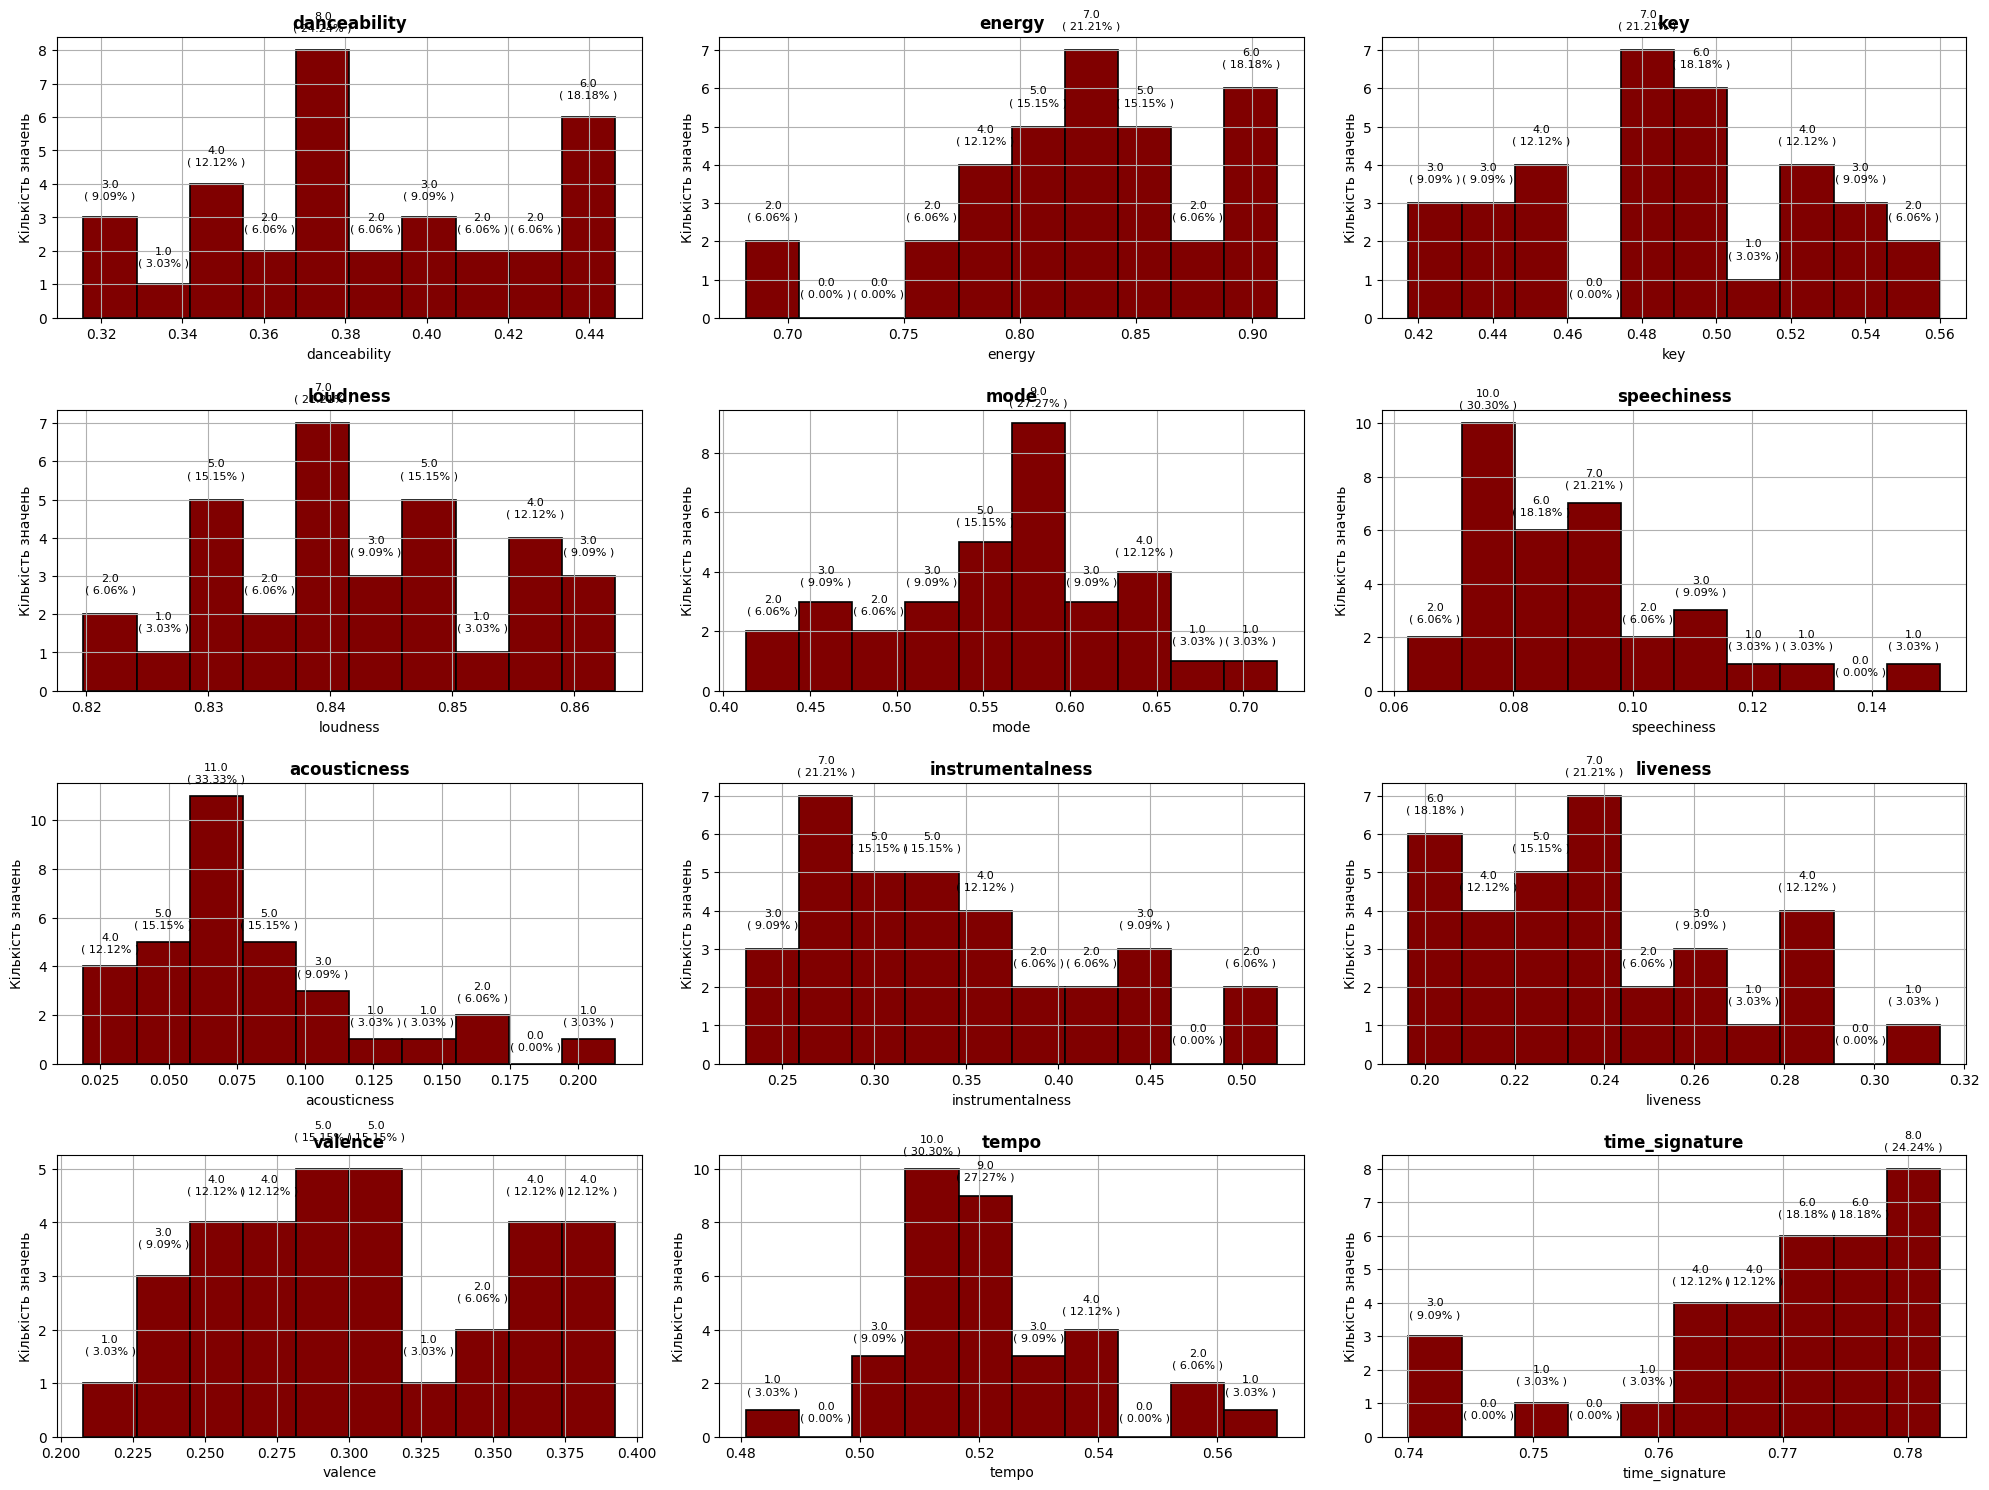

In [185]:
plot_all_features(data=expl_data)

# **Виведемо порівнння фіч кожного кластера**

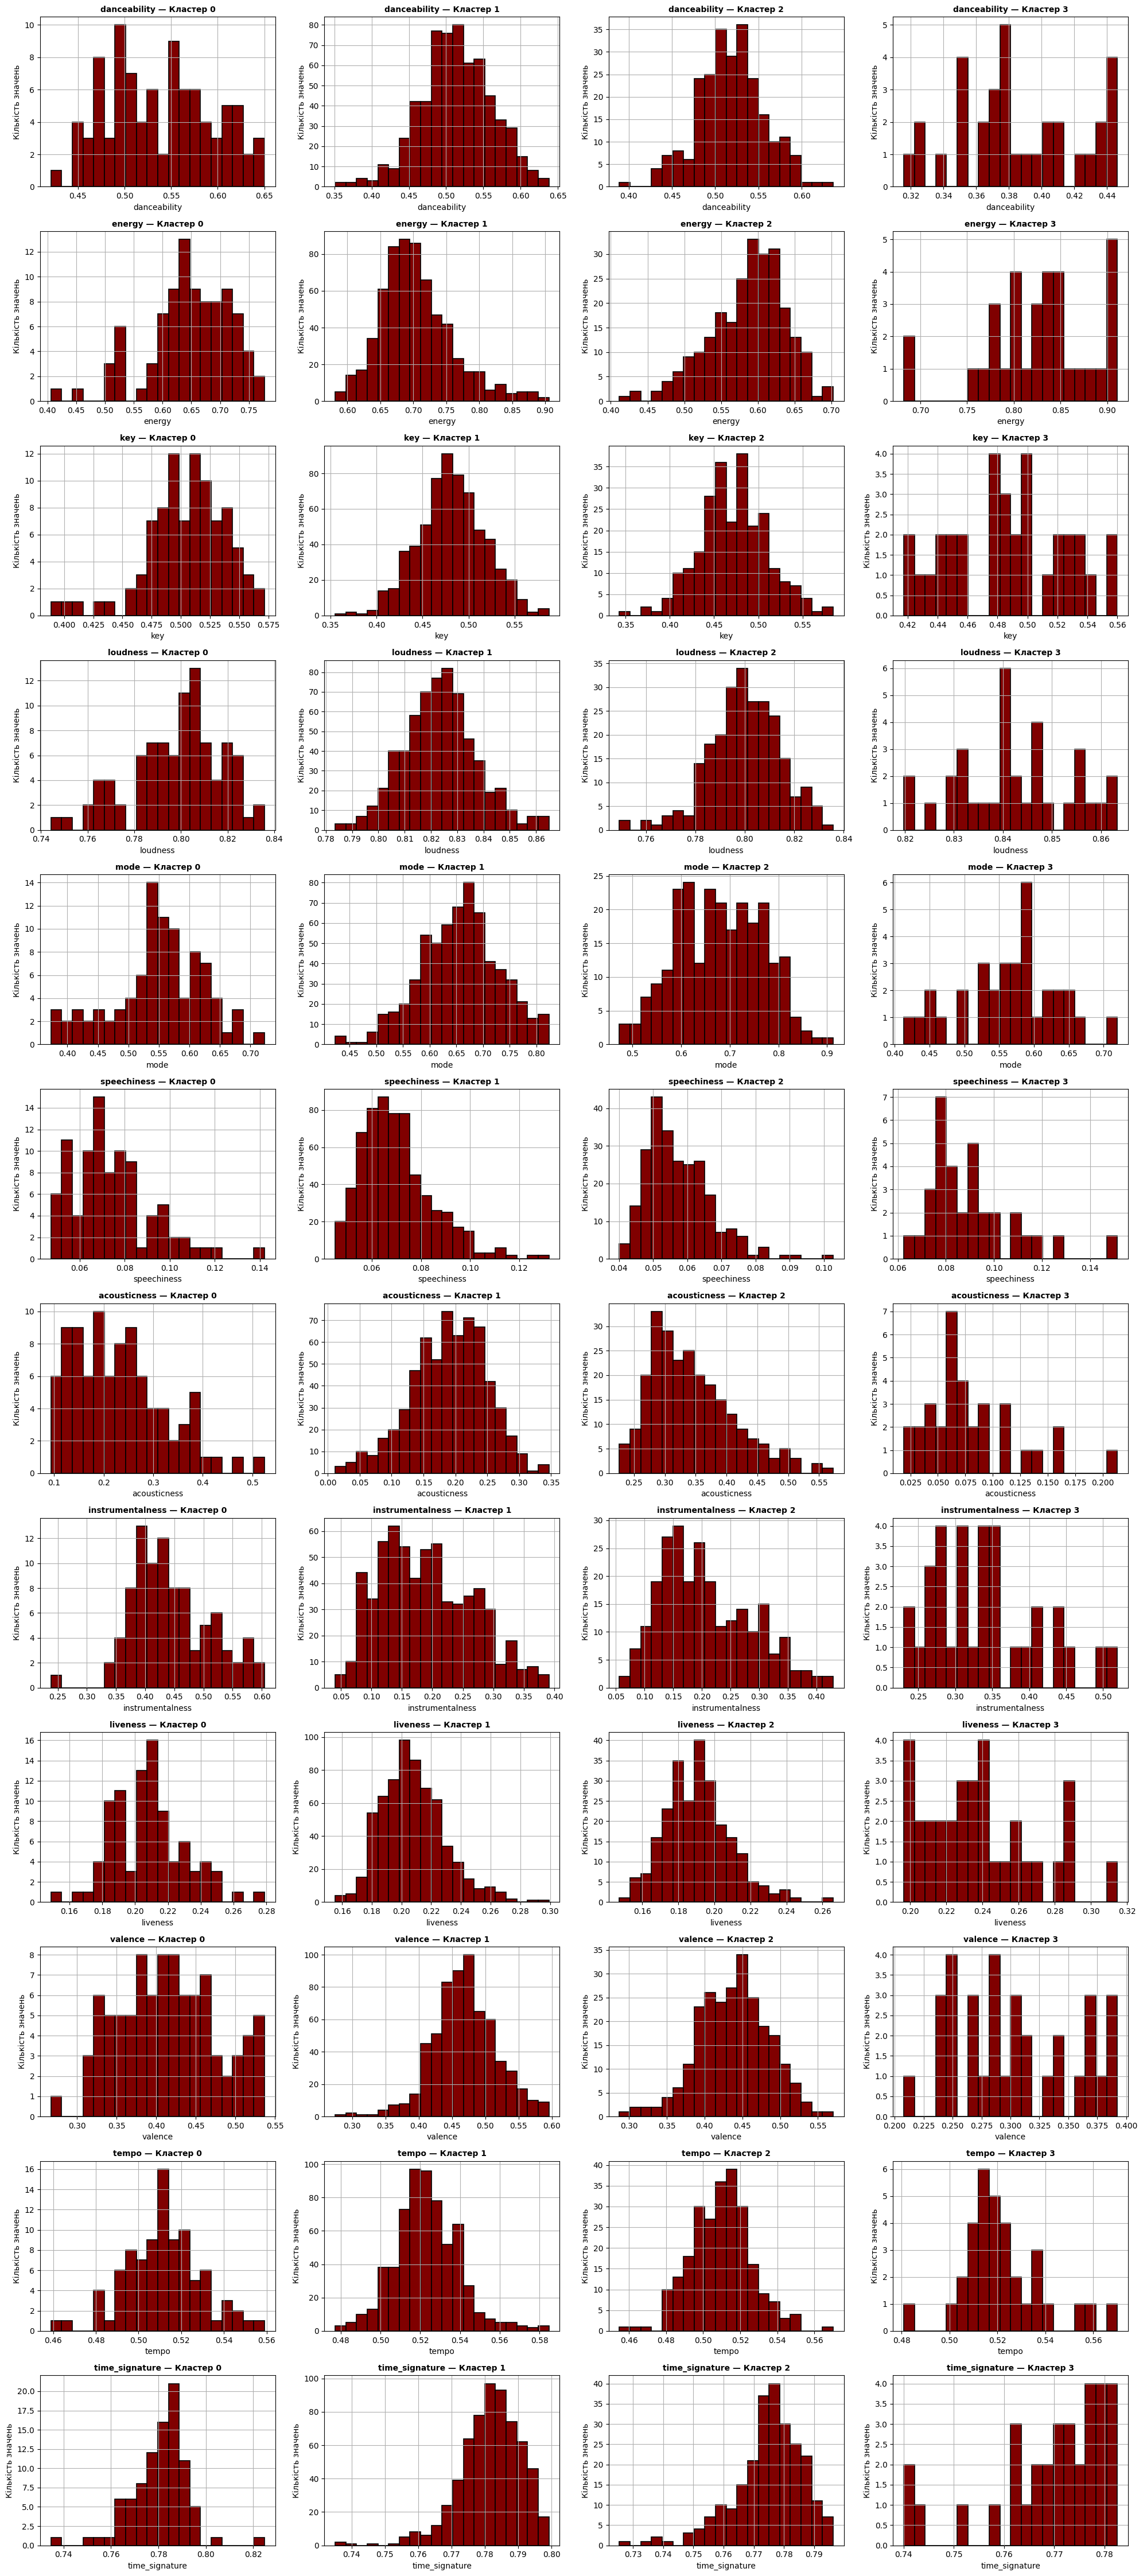

In [186]:
plot_features_comparisson(data=df_profiles, cluster_column_name='cluster', features=features)

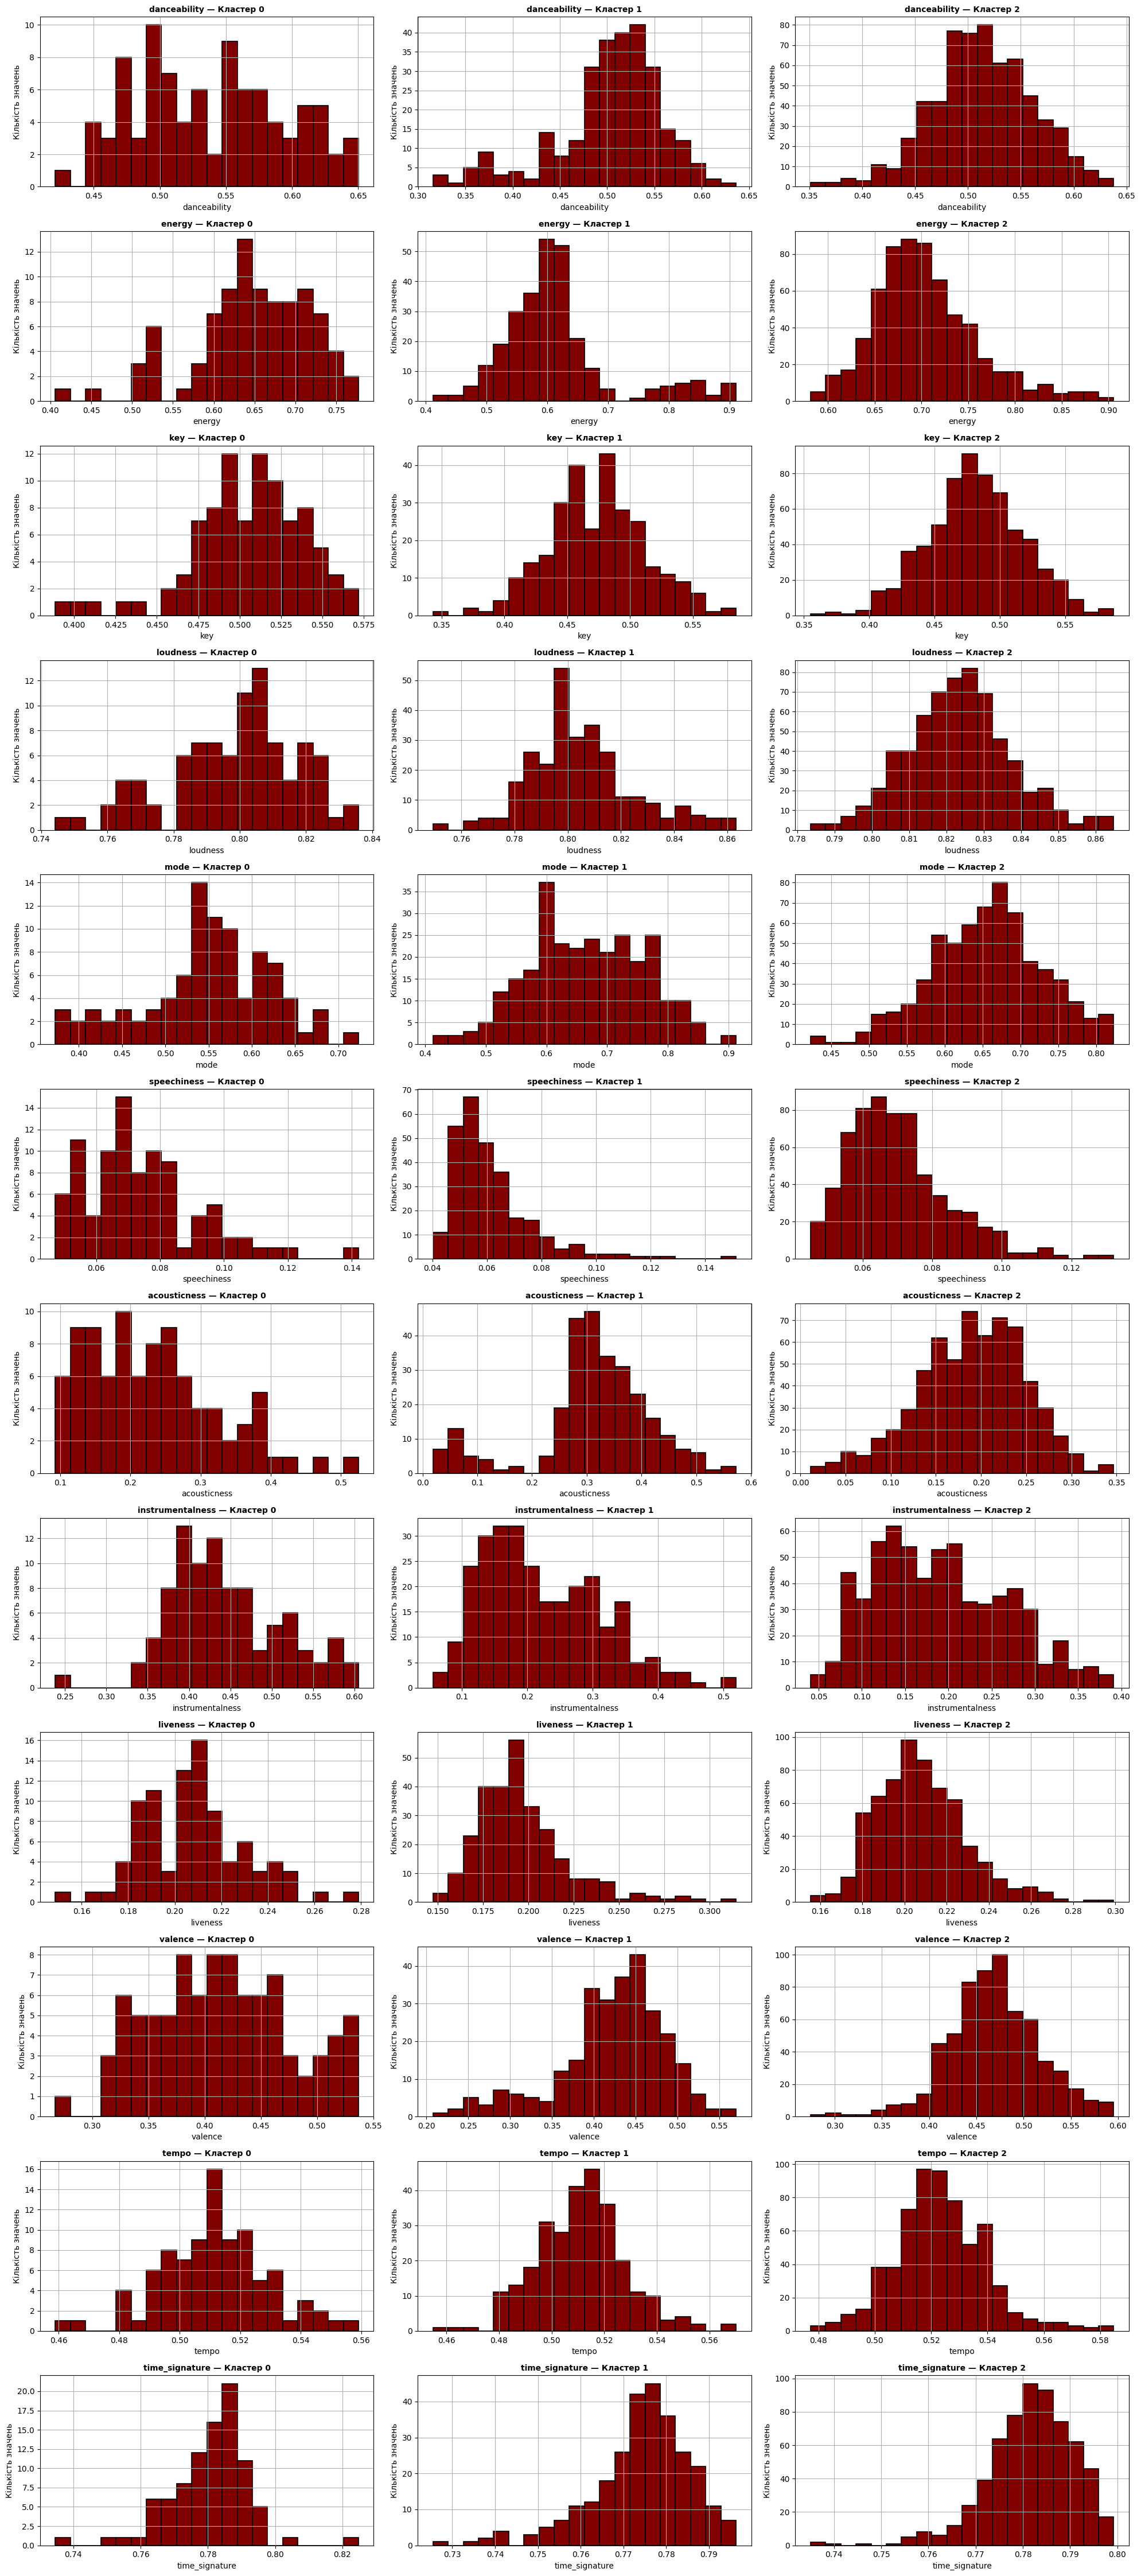

In [199]:
plot_features_comparisson(data=df_profiles, cluster_column_name='cluster_norm', features=features)

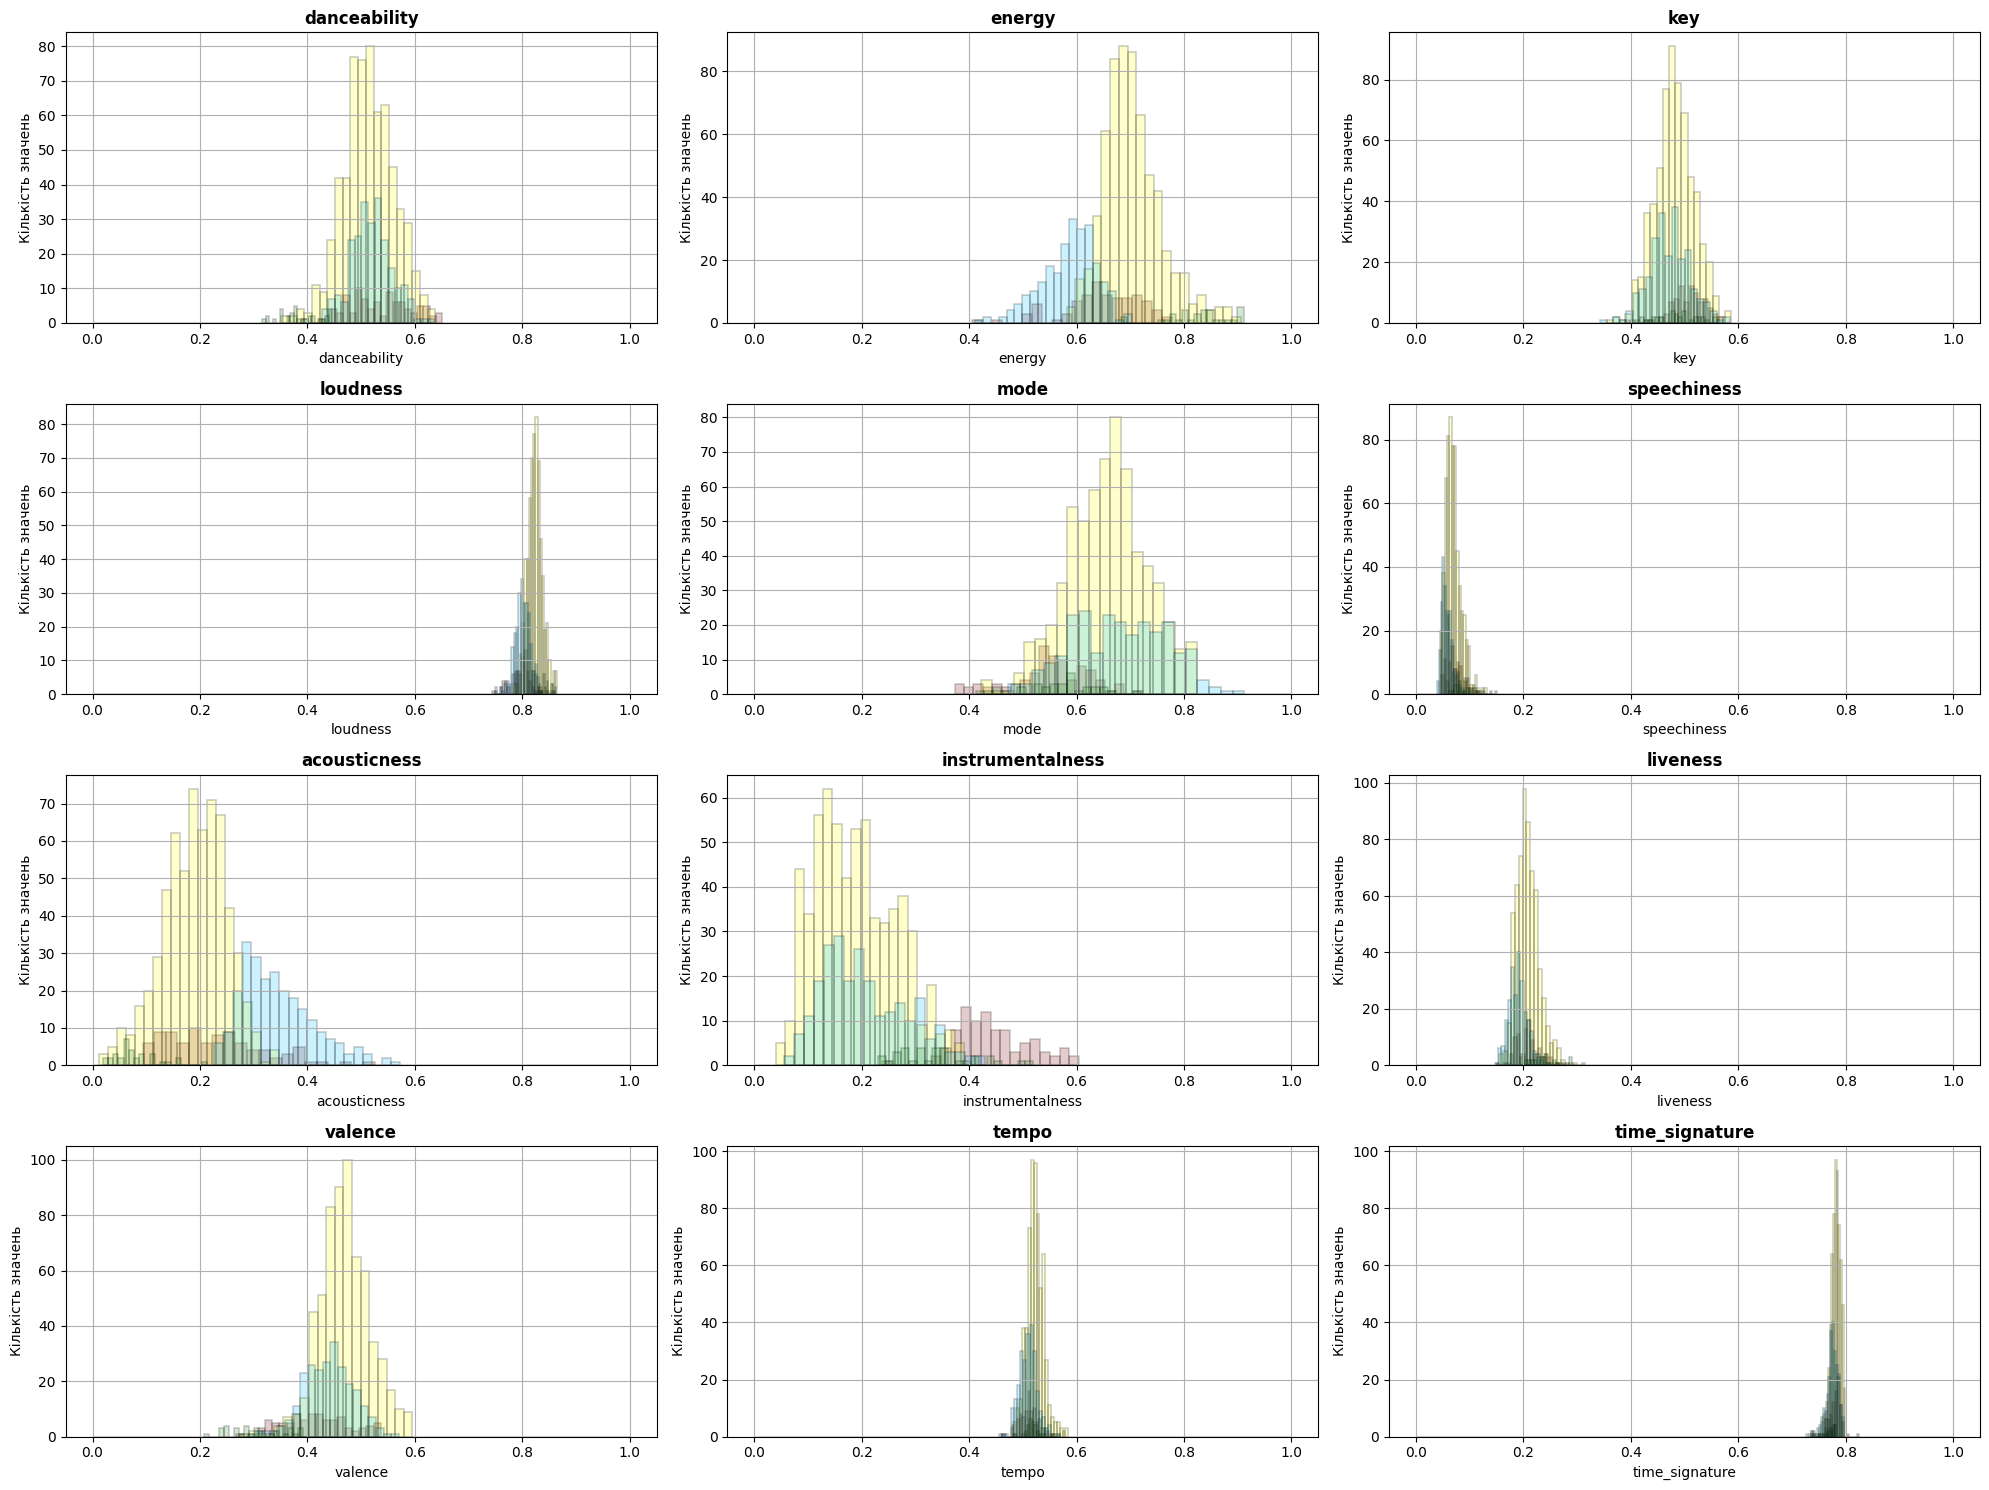

In [187]:
plot_features_comparisson_overlaping(data=df_profiles, cluster_column_name='cluster', features=features)

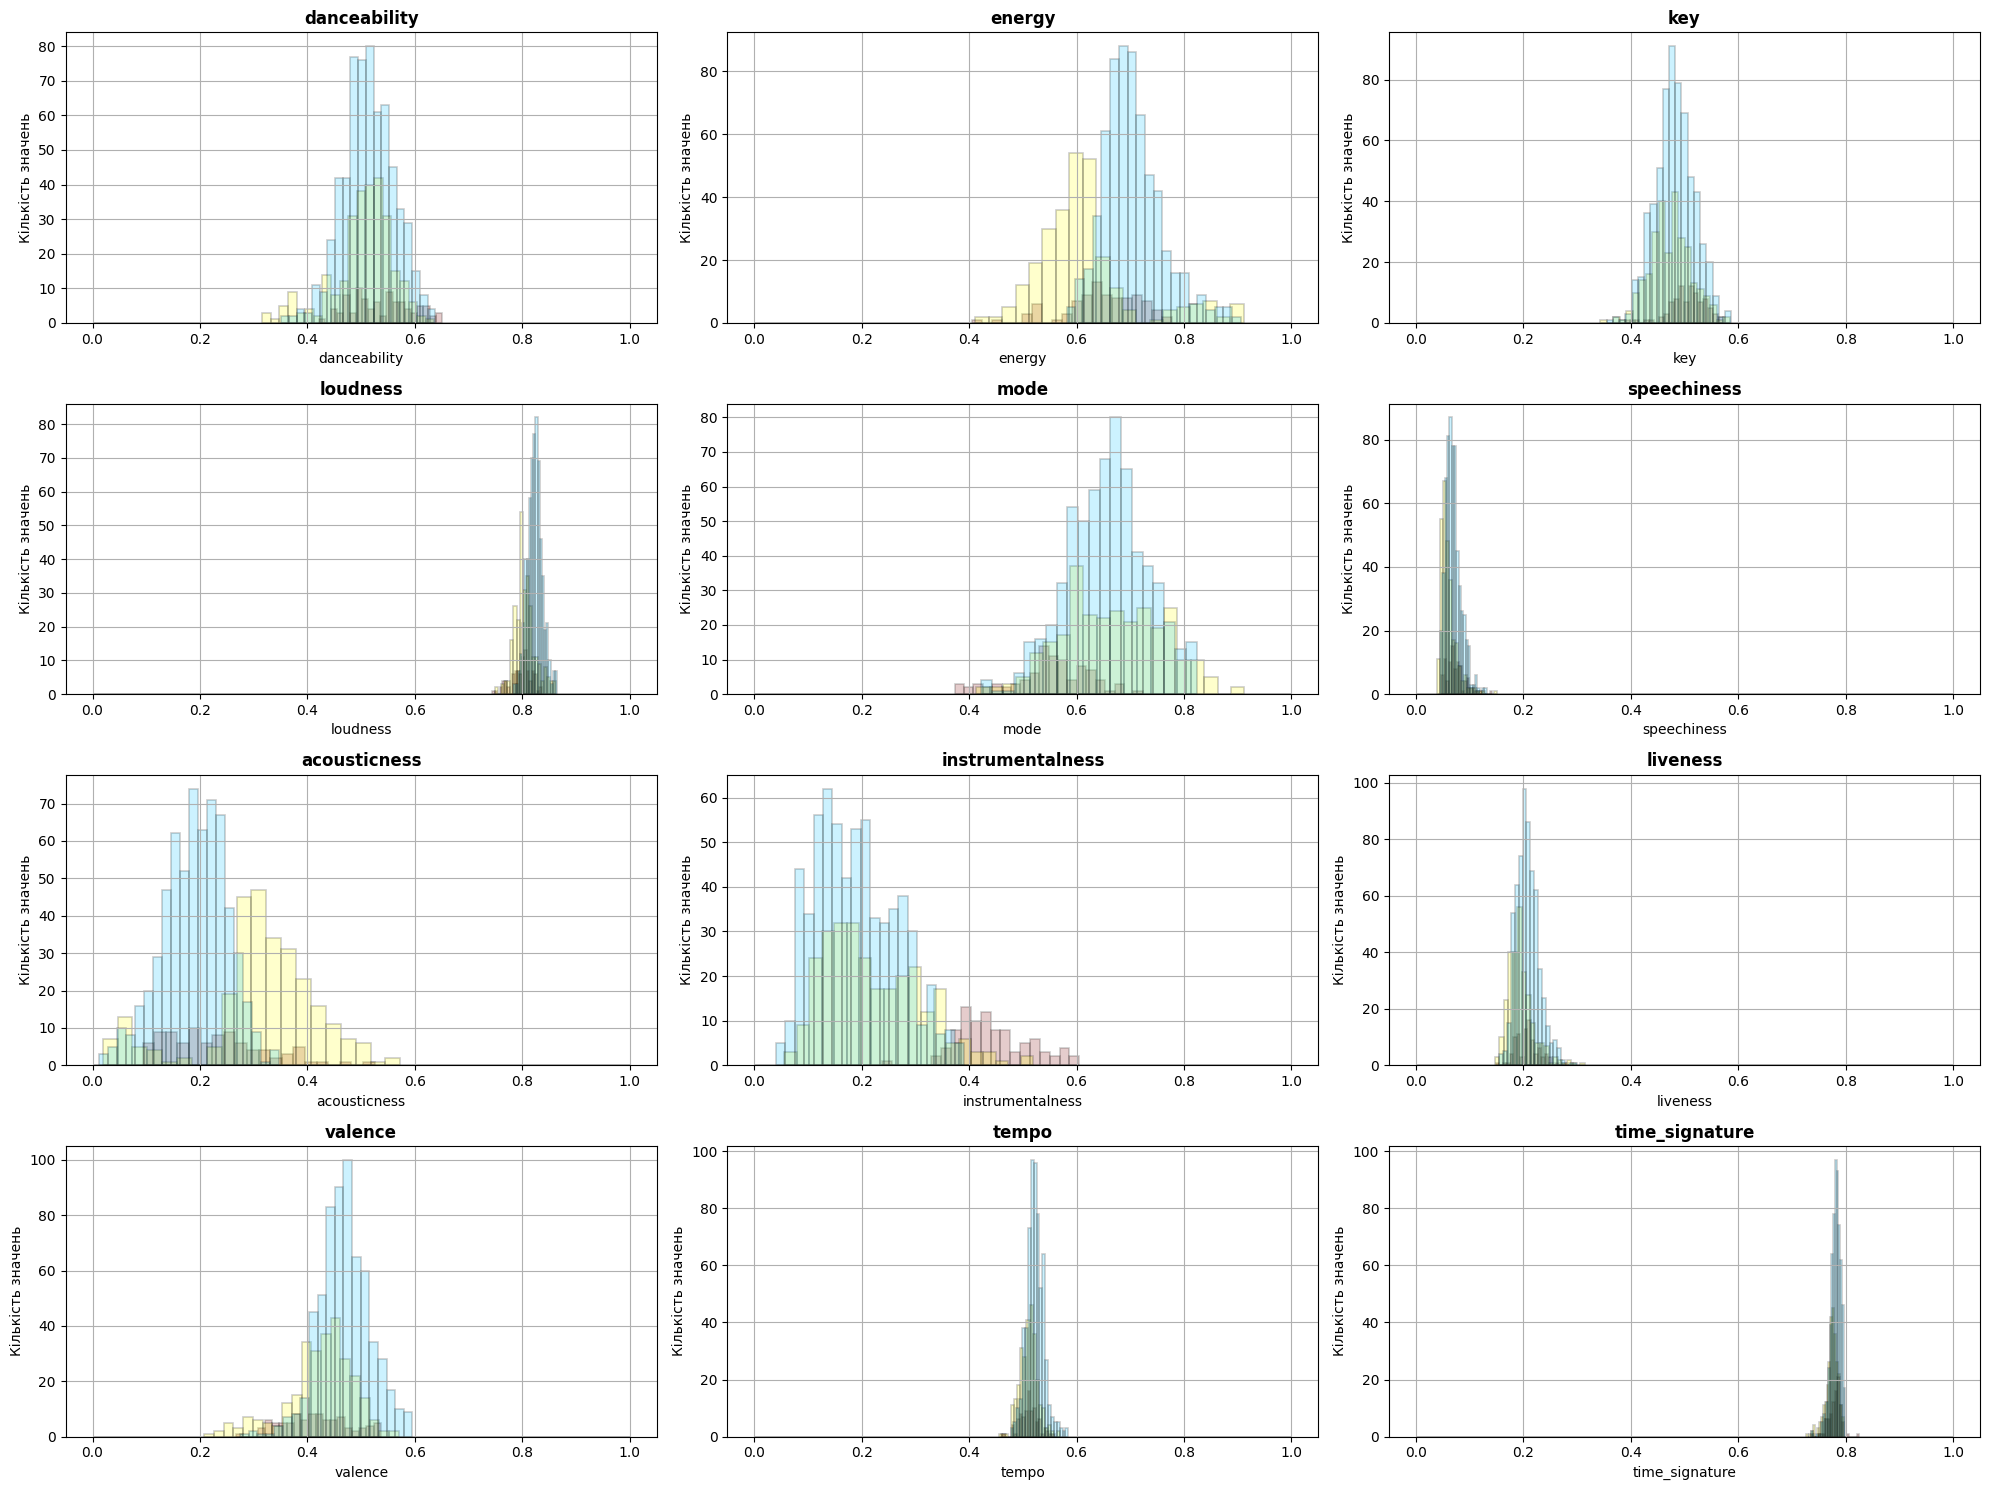

In [197]:
plot_features_comparisson_overlaping(data=df_profiles, cluster_column_name='cluster_norm', features=features)

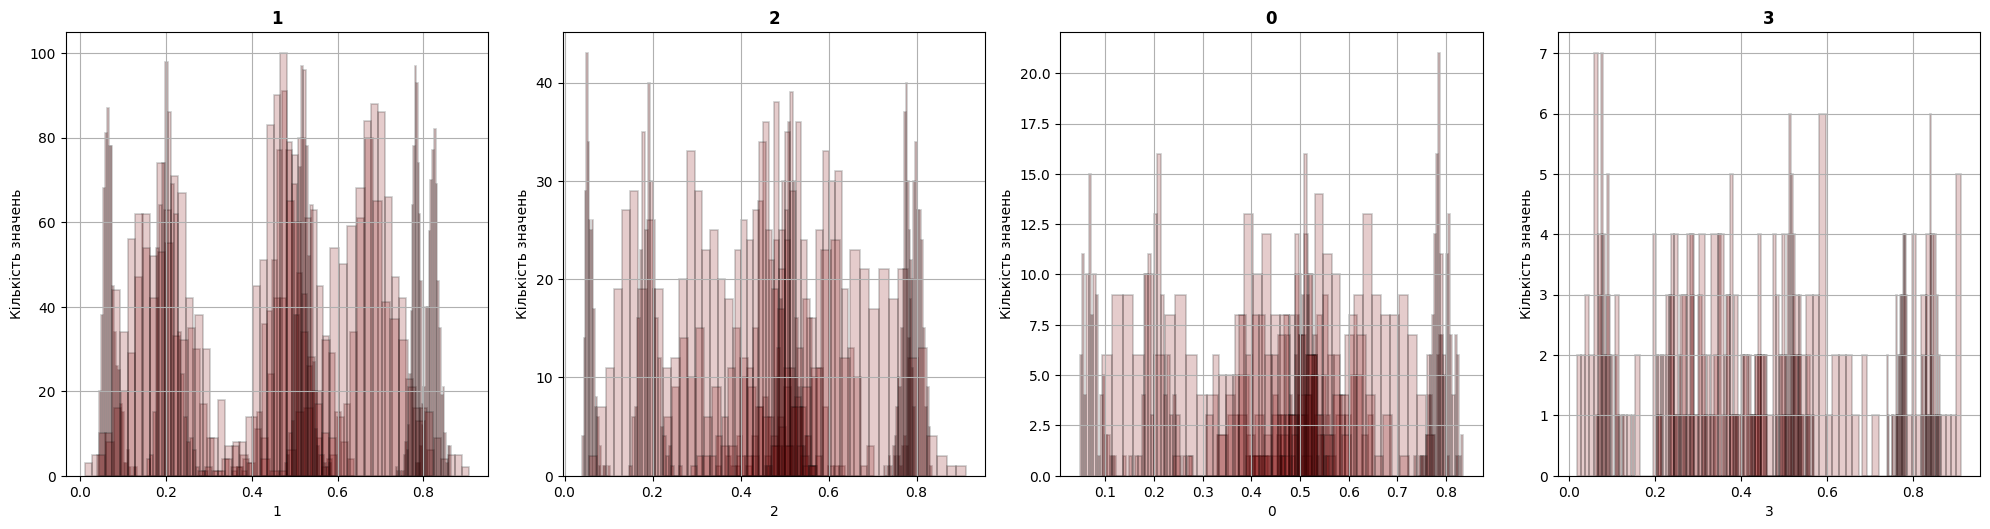

In [189]:
plot_clusters_overlaping(data=df_profiles, cluster_column_name='cluster', features=features)

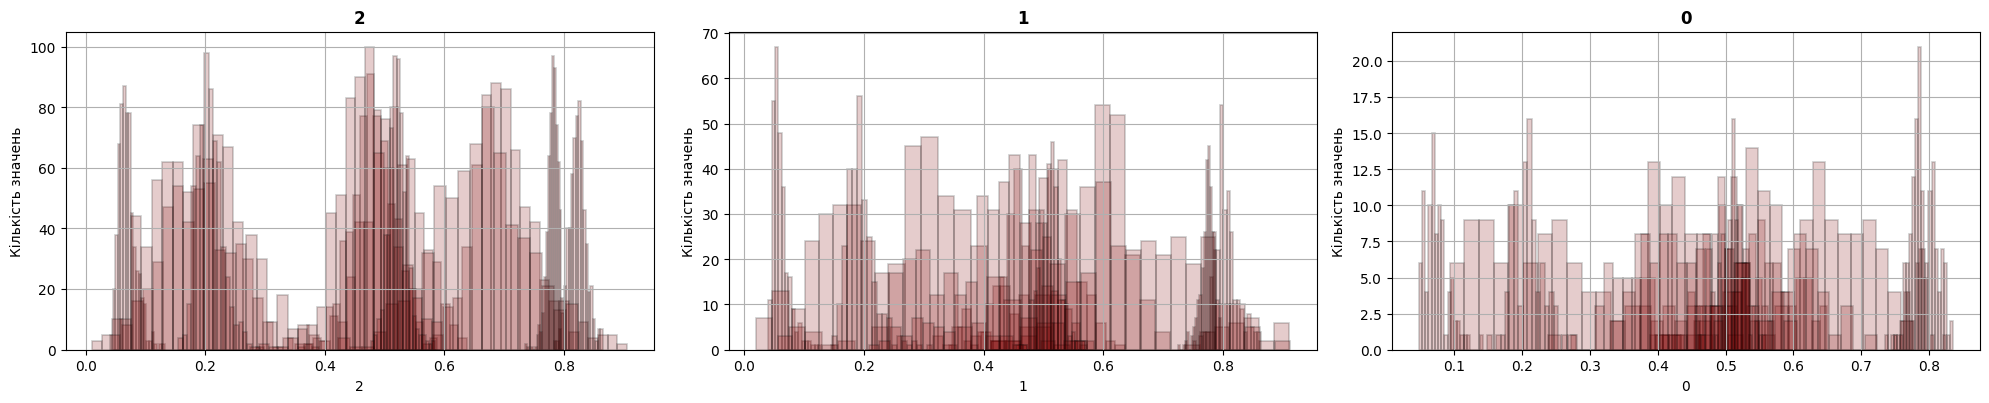

In [198]:
plot_clusters_overlaping(data=df_profiles, cluster_column_name='cluster_norm', features=features)

In [192]:
df_profiles.index.name = 'user_id'
df_profiles.to_csv('./data/User_Profiles_hierarchical_clusterized.csv')

In [200]:
df_profiles.index.name = 'user_id'
df_profiles.to_csv('./data/User_Profiles_hierarchical_clusterized_with_norm.csv')